## Carregamento do Dataset, Pré-processamento e Normalização refinados para português
* Normalização de texto:
    * Conversão para minúsculas.
    * Remoção de acentos (unidecode).
    * Substituição de caracteres especiais.
* Limpeza:
    * Remoção de URLs, menções (@usuario), hashtags, espaços, números, pontuações e outros acentos e emojis.
    * Remoção de Stopwords.
* Tokenização:
    * Segmentação em palavras ou subpalavras (wordtokenizer), especialmente útil em português por causa da morfologia rica.

## Random Forest + Feature Engineering Tradicional
* Bag-of-Words (BoW): baseline simples.
* TF-IDF: mais robusto para capturar relevância.
* N-grams: bigramas e trigramas são úteis em discurso de ódio (ex.: “vai morrer”, “seu lixo”):
    * Utilizado unigrama.
* Levantamento de erros na classificação.

## Regressão Logística
* Vetorizador híbrido: palavra (1–2) + caractere (3–5).
* Dois vetores são concatenados via FeatureUnion-like simples por Pipeline separado.

## BERTimbau (Transformer - variação do BERT)
* Usa transformers (Hugging Face).
* Estratégia: fine-tuning em BERTimbau-base.
* Entrada: texto cru (sem lematização/stemming, apenas limpeza mínima).
* Saída: classificação binária.
* Word embeddings pré-treinados:
    * Word2Vec, FastText (bom para português por lidar com morfologia e palavras raras).
* Contextual embeddings:
    * BERTimbau e GPT-like models ajustados para português.
* Fine-tuning de Transformers:
    * Ajuste fino em datasets anotados de discurso de ódio.

## Observações
* Random Forest e Regressão Logística: baseline clássico, útil para entender ganhos relativos.
* BERTimbau: modelo contextual já pré-treinado em português, se adapta bem ao domínio devido ao ajuste via fine-tuning.
* LLaMA3 + LoRA: não utilizado apenas como um modelo genérico em prompting, foi adaptado ao OFFCOMBR, aprendendo padrões ofensivos específicos do português.
    * Com isso, o LLaMA3 ganha competitividade real contra o BERTimbau.
    * A comparação passa a ser mais justa, porque ambos (BERTimbau e LLaMA3) estão sendo fine-tunados no mesmo dataset.
    * A diferença é que, com LoRA, o LLaMA3 deixa de ser apenas um baseline de prompting e passa a ser um concorrente direto do BERTimbau.
    * Isso enriquece a análise, porque podemos ver quanto o fine-tuning eficiente (LoRA) melhora um LLM genérico em relação a um modelo já especializado em português (BERTimbau).

## Avaliação dos modelos
* Comparação de métricas.
* Curvas ROC e AUC.
* Curvas Precision-Recall (PRC).
* Barplot comparativo.
* Matriz de confusão
* Heatmap de correlação

# Visão geral do notebook

O notebook implementa um pipeline completo para detecção de discurso de ódio em português com o corpus OFFCOMBR (OffComBR2.arff e OffComBR3.arff), cobrindo: carregamento direto do GitHub, normalização de rótulos para binário (`label_int`), pré-processamento, exploração de TF-IDF (com visualização e redução opcional via SVD/UMAP), treinamento de quatro famílias de modelos (Random Forest, Regressão Logística, BERTimbau e LLaMA 3 8B com LoRA/quantização 4-bit), explicabilidade via SHAP (nível de token/feature) e avaliação consolidada (métricas, matrizes de confusão, curvas ROC/PR e análise de erros).

# Pré-processamento e preparação de dados

* Limpeza: lowercasing; remoção de URLs, menções, hashtags, dígitos e pontuação; normalização com *unidecode*; colapso de espaços.
* Tokenização (NLTK/PT), remoção de stopwords personalizadas e de tokens vazios/curtos; deduplicação de tokens por documento; geração opcional de n-grams (padrão: unigramas).
* Remoção de documentos vazios/duplicados após limpeza.
* *Splits* estratificados de treino/teste são persistidos para reprodutibilidade entre execuções e modelos.
* Estatísticas auxiliares: contagens de tokens, distribuição de sentenças e visualizações 2D de TF-IDF.

# Modelos e treinamento

**Random Forest (baseline clássico)**

* *Pipeline*: `TfidfVectorizer` (unigramas, vocabulário até 20k) → `RandomForestClassifier` com balanceamento.
* Saídas: métricas (accuracy, precisão/recall/F1 macro), relatório de classificação, exemplos mal previstos.

**Regressão Logística (baseline clássico)**
* *Pipeline*: `TfidfVectorizer híbrido` (n-grams para caracter(3-5) e para palavra(1-2)) → `LogisticRegression` com balanceamento.
* Saídas: métricas (accuracy, precisão/recall/F1 macro), relatório de classificação, exemplos mal previstos.

**BERTimbau (Transformer em PT)**

* *Checkpoint*: `neuralmind/bert-base-portuguese-cased` com cabeça de classificação binária.
* Treino com Hugging Face `Trainer` (épocas, *batch sizes* e *collator* configuráveis; GPU com FP16/BF16 quando disponível).
* Métricas macro, relatório de erros e matriz de confusão.

**LLaMA 3 8B + LoRA (quantização 4-bit)**

* *Checkpoint*: `meta-llama/Meta-Llama-3-8B-Instruct`.
* Quantização NF4 (bitsandbytes) + PEFT/LoRA (r=16) com *gradient checkpointing*; *datasets* HF tokenizados para *max_length* fixo.
* Treino/avaliação via `Trainer`, salvando *tokenizer* e *adapters*; relatório de métricas, matriz de confusão e curva ROC/AUC.

# Explicabilidade (SHAP)

* **RF**: `shap.TreeExplainer` com *background* do treino; ranking global de tokens por |SHAP| médio e gráficos locais (contribuições assinadas) por instância.
* **BERTimbau e LLaMA**: *wrapper* `predict_proba` + `shap.maskers.Text`; explicações por token (globais: |SHAP| médio e sinal; locais: contribuições por amostra), alinhadas visualmente ao RF.

# Avaliação consolidada e interpretação de erros

* Consolidação das probabilidades de cada modelo para calcular métricas macro (accuracy, precisão, recall, F1) e da classe positiva; geração de tabelas comparativas, *barplots* (accuracy/F1), curvas ROC e Precision–Recall, matrizes de confusão e *heatmaps* de correlação entre métricas.
* Rotina de análise de erros: seleciona amostras em que pelo menos um modelo errou e mostra, para cada modelo, as previsões e gráficos SHAP locais (TF-IDF para Random Forest e Regressão Logística; tokens para BERTimbau/LLaMA), facilitando a inspeção de divergências entre abordagens.

## 1. Configurações Iniciais


In [2]:
import os, json, random, warnings, numpy as np, pandas as pd
import urllib.request
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import ConfusionMatrixDisplay
from datasets import Dataset
import shap
import evaluate
import datasets as hfds
import torch
import arff
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, TensorDataset
from packaging import version as _pkgver
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, Trainer, TrainingArguments,
                          AutoModelForCausalLM)
warnings.filterwarnings("ignore")

try:
    from transformers import BitsAndBytesConfig
    from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
    HAS_PEFT = True
except Exception:
    HAS_PEFT = False

# UMAP é usado para redução dimensional mais “não linear”
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

SEED = 42
random.seed(SEED); np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_prec = evaluate.load("precision")
metric_rec = evaluate.load("recall")

### 1.1 Parâmetros do experimento


In [4]:
CONFIGS = ["offcombr-2", "offcombr-3"]
TEST_SIZE = 0.20
MAX_FEATURES_TFIDF = 20000
MAX_LEN_BERT = 128
BATCH_TRAIN = 16
BATCH_EVAL = 32
EPOCHS_BERT = 3
LR_BERT = 2e-5

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

In [5]:
# -------------------------
# Custom Portuguese stopwords
# -------------------------
STOPWORDS_PT = set([
    'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns',
    'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio',
    'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás',
    'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'cedo',
    'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra',
    'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo',
    'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses',
    'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria',
    'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse',
    'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela',
    'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse',
    'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este',
    'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram',
    'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes',
    'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer',
    'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram',
    'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande',
    'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas',
    'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houverem', 'houveremos', 'houveria', 'houveríamos',
    'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo',
    'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor',
    'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento',
    'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'nao', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas',
    'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém',
    'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo',
    'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde',
    'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas',
    'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode',
    'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto',
    'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas',
    'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios',
    'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto',
    'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres',
    'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo',
    'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos',
    'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim',
    'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco',
    'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham',
    'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam',
    'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver',
    'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste',
    'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo',
    'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm',
    'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa',
    'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_'
])

## 2. Carregamento e Pré-processamento do OFFCOMBR ##


In [6]:
# =========================
# 1. Carregamento OFFCOMBR
# =========================
GITHUB_RAW_BASE = "https://raw.githubusercontent.com/rogersdepelle/OffComBR/master"
ARFF_URLS = {
    "offcombr-2": f"{GITHUB_RAW_BASE}/OffComBR2.arff",
    "offcombr-3": f"{GITHUB_RAW_BASE}/OffComBR3.arff",
}

def load_offcombr(cfg="offcombr-2"):
    if cfg not in ARFF_URLS:
        raise ValueError("Use 'offcombr-2' ou 'offcombr-3'")
    raw = urllib.request.urlopen(ARFF_URLS[cfg]).read().decode("utf-8", errors="ignore")
    obj = arff.loads(raw)
    cols = [a[0] for a in obj["attributes"]]
    df = pd.DataFrame(obj["data"], columns=cols)
    if "document" in df.columns:
        df = df.rename(columns={"document": "text"})
    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"] != ""].copy()
    class_col = next((c for c in df.columns if "class" in c.lower()), None)
    if class_col is None:
        raise ValueError("Não foi encontrada coluna de classe no ARFF")
    df["label_int"] = df[class_col].astype(str).str.lower().map({"no":0,"yes":1,"not":0,"offensive":1}).astype(int)
    return df[["text","label_int"]]

def _unique_preserve_order(tokens):
    seen = set()
    out = []
    for t in tokens:
        if t not in seen:
            seen.add(t)
            out.append(t)
    return out

def clean_text(text):
    """Normaliza texto: lower, remove links/mentions/hashtags/números/pontuação, remove acentos e espaços extras."""
    if not isinstance(text, str):
        return ""
    new_text = text.lower()
    new_text = re.sub(r"http\S+|www\S+|https\S+", " ", new_text)    # Punctuation and other symbols
    new_text = re.sub(r"@\S+", " ", new_text)                       # Removing Links
    new_text = re.sub(r"#\S+", " ", new_text)                       # Remove Hashtags
    new_text = re.sub(r"[0-9]+", " ", new_text)                     # Remove number and words with numbers
    new_text = re.sub(r"[^\w\s]", " ", new_text)                    # Remove accents
    new_text = unidecode(new_text)                                  # Remove spaces
    new_text = re.sub(r"\s+", " ", new_text).strip()
    return new_text

def preprocess_text(df, n_grams=1, min_token_len=2, remove_stopwords=True):
    """
    Recebe DataFrame com coluna `text`. Retorna:
      - df_processed: lista de strings processadas (n_grams applied; por padrão unigram)
      - index_to_drop: índices originais removidos (vazios / nulos / duplicados)
    Comportamento:
      - remove tokens nulos/'0' e tokens muito curtos
      - remove stopwords (array custom)
      - remove tokens duplicados dentro do documento (mantendo ordem)
      - NÃO aplica stemming (mantém tokens normalizados)
      - gera n-grams se n_grams > 1
      - remove documentos duplicados após processamento
    """
    df = df.copy()

    # 1) limpeza básica
    df['text_clean'] = df['text'].apply(clean_text)

    # 2) tokenização, remoção de stopwords, tokens nulos/zeros/curtos e duplicação
    def tokens_process(text):
        if not text:
            return []
        toks = word_tokenize(text, language='portuguese')
        proc = []
        for t in toks:
            if not t:
                continue
            if t == "0":
                continue
            if len(t) < min_token_len:
                continue
            if remove_stopwords and t in STOPWORDS_PT:
                continue
            proc.append(t)
        # remove duplicados dentro do documento mantendo ordem
        proc = _unique_preserve_order(proc)
        return proc

    df['tokens'] = df['text_clean'].apply(tokens_process)

    # 3) descartar documentos sem tokens
    index_to_drop = []
    empty_idx = df[df['tokens'].map(len) == 0].index.tolist()
    index_to_drop.extend(empty_idx)
    df = df[~df.index.isin(empty_idx)]

    # 4) geração de n-grams (sem stemming)
    def tokens_to_ngrams(tokens):
        if not tokens:
            return ""
        if n_grams == 1:
            return " ".join(tokens)
        grams = list(ngrams(tokens, n_grams))
        joined = ["_".join(g) for g in grams]  # usa underscore para juntar termos do n-gram
        return " ".join(joined)

    df['text_processed'] = df['tokens'].apply(tokens_to_ngrams)

    # 5) remover duplicados entre documentos (com base em text_processed)
    dup = df[df.duplicated(subset=['text_processed'], keep='first')]
    dup_idx = dup.index.tolist()
    index_to_drop.extend(dup_idx)
    df = df.drop(dup_idx)

    # 6) preparar saída
    df.reset_index(drop=True, inplace=True)
    df_processed = df['text_processed'].astype(str).tolist()

    return df_processed, index_to_drop

def corpus_stats_before_after(df):
    original_len = df["text"].apply(lambda x: len(str(x).split())).sum()
    processed = df["text_pp"].apply(lambda x: len(str(x).split())).sum()
    print(f"Tokens totais - antes: {original_len} | depois: {processed} | var: {processed-original_len}")
    return original_len, processed

In [7]:
# Check de sanidade por variante (tamanho e balanceamento)
for cfg in CONFIGS:
    df = load_offcombr(cfg)
    n = len(df)
    pos = df["label_int"].sum()
    neg = n - pos
    print(f"{cfg}: total={n} | ofensivo={pos} ({pos/n:.1%}) | nao_ofensivo={neg} ({neg/n:.1%})")

offcombr-2: total=1250 | ofensivo=419 (33.5%) | nao_ofensivo=831 (66.5%)
offcombr-3: total=1033 | ofensivo=202 (19.6%) | nao_ofensivo=831 (80.4%)


In [8]:
# Persisti e reutiliza os índices do split (mesmo split para todos os modelos)
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

def make_or_load_split_indices(cfg, y, test_size=0.20, seed=42):
    split_path = os.path.join(ARTIFACTS_DIR, f"indices_split_{cfg}.json")
    n = len(y)
    if os.path.exists(split_path):
        data = json.load(open(split_path, "r", encoding="utf-8"))
        train_idx = np.array(data["train_idx"])
        test_idx  = np.array(data["test_idx"])
    else:
        all_idx = np.arange(n)
        train_idx, test_idx = train_test_split(
            all_idx, test_size=test_size, stratify=y, random_state=seed
        )
        json.dump({"train_idx": train_idx.tolist(), "test_idx": test_idx.tolist()},
                  open(split_path, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
    return train_idx, test_idx

### 2.1 Aplicar pré-processamento e criar *splits*


In [9]:
# Aplica pré-processamento e criar *splits* (usando índices persistidos)
splits = {}

def apply_preprocess_to_df(df, n_grams=1, min_token_len=2, remove_stopwords=True, fill_empty=""):
    df_orig = df.copy()
    df_processed, index_to_drop = preprocess_text(
        df_orig, n_grams=n_grams,
        min_token_len=min_token_len,
        remove_stopwords=remove_stopwords
    )

    remaining_idx = [i for i in df_orig.index if i not in index_to_drop]
    if len(remaining_idx) != len(df_processed):
        raise RuntimeError("Tamanho incompatível entre índices restantes e textos processados.")

    # Preenche coluna text_pp
    df_orig['text_pp'] = pd.NA
    s = pd.Series(df_processed, index=remaining_idx)
    df_orig.loc[remaining_idx, 'text_pp'] = s

    # Só preenche os removidos se o usuário pediu
    if fill_empty is not None:
        df_orig.loc[index_to_drop, 'text_pp'] = fill_empty

    return df_orig, index_to_drop

for cfg in CONFIGS:
    print(f"\n=== Processando {cfg} ===")
    df = load_offcombr(cfg)
    # Pré-processamento (tokenização PT, stopwords, remoção de duplicação, unigramas - n_grams = 1)
    df_pp, dropped_idx = apply_preprocess_to_df(df, n_grams=1, min_token_len=2, remove_stopwords=True, fill_empty="")
    _ = corpus_stats_before_after(df_pp)

    # Cria ou carrega índices fixos de split para este cfg
    train_idx, test_idx = make_or_load_split_indices(cfg, df_pp["label_int"].values, test_size=TEST_SIZE, seed=SEED)

    # Aplica índices para construir X/y de treino e teste
    X_train = df_pp.loc[train_idx, "text_pp"].values
    y_train = df_pp.loc[train_idx, "label_int"].values
    X_test  = df_pp.loc[test_idx,  "text_pp"].values
    y_test  = df_pp.loc[test_idx,  "label_int"].values

    splits[cfg] = {
        "train_text": X_train, "train_y": y_train,
        "test_text":  X_test,  "test_y":  y_test,
        # Guarda o texto bruto (sem pré-processar) para análise de erro
        # "train_text_raw": df.loc[train_idx, "text"].values,
        # "test_text_raw":  df.loc[test_idx,  "text"].values,
        # "train_idx": train_idx, "test_idx": test_idx
    }

print("\nSplits prontos para OFFCOMBR-2 e OFFCOMBR-3 (com índices persistidos).")


=== Processando offcombr-2 ===
Tokens totais - antes: 16235 | depois: 7852 | var: -8383

=== Processando offcombr-3 ===
Tokens totais - antes: 13914 | depois: 6652 | var: -7262

Splits prontos para OFFCOMBR-2 e OFFCOMBR-3 (com índices persistidos).


## 3. Exploração do Corpus com TF‑IDF
  - Calcular representações TF-IDF no conjunto de treino
   - Explorar tokens mais “importantes” (em média)
   - Exibir distribuição de tokens e sentenças (em PT)
   - Visualizar o espaço TF-IDF em 2D (SVD ou UMAP)


=== Exploração TF-IDF (offcombr-2) ===


,token,tfidf_mean
0,so,0.016104
1,pra,0.015767
2,ja,0.014541
3,ta,0.012126
4,brasil,0.011157
5,sao,0.010977
6,cara,0.010108
7,melhor,0.009756
8,voce,0.008472
9,ai,0.008193


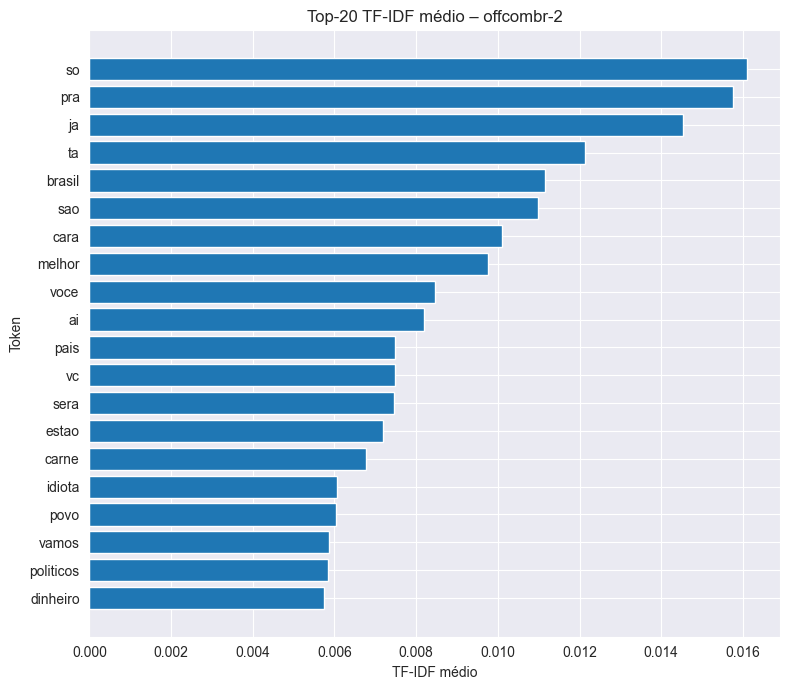


Palavras mais frequentes (tokenização PT - amostra):
so            75
pra           72
ja            64
ta            47
sao           46
brasil        44
melhor        31
cara          31
pais          28
ai            26
carne         26
estao         25
voce          25
politicos     24
ate           24
sera          23
vc            22
povo          22
dinheiro      21
vamos         19
ficar         18
temer         18
pro           17
propria       17
presidente    16
bosta         16
entao         15
ne            15
pec           15
boca          14

Distribuição de sentenças (PT - amostra):
count    1000.000000
mean        0.987000
std         0.113331
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000

Visualização 2D do TF-IDF (treino):


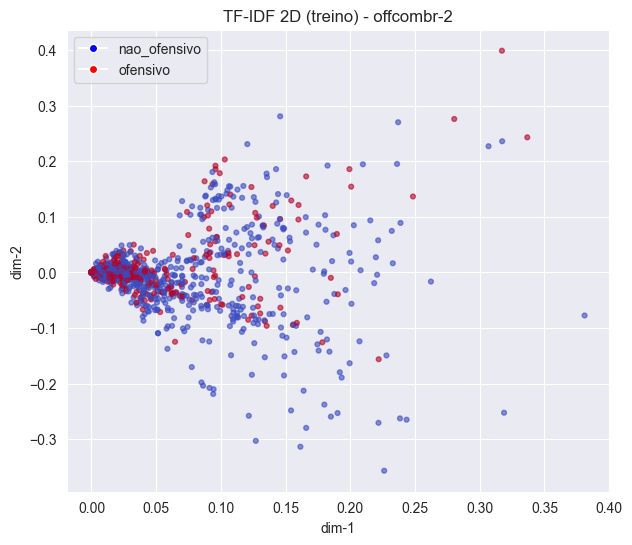


=== Exploração TF-IDF (offcombr-3) ===


,token,tfidf_mean
0,so,0.016924
1,pra,0.016473
2,ja,0.015010
3,ta,0.013119
4,brasil,0.012830
5,sao,0.012239
6,cara,0.011024
7,melhor,0.010924
8,voce,0.008812
9,sera,0.008657


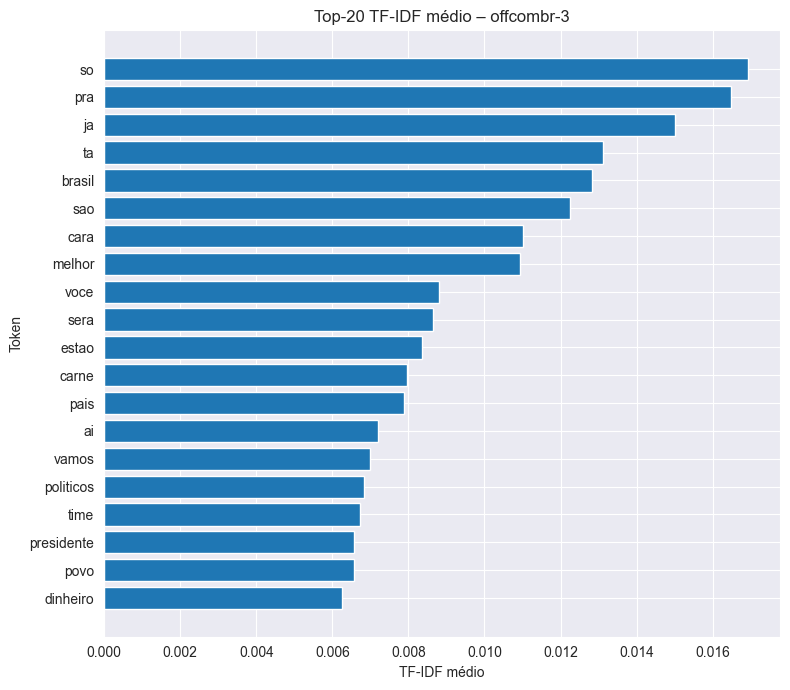


Palavras mais frequentes (tokenização PT - amostra):
so            65
pra           62
ja            57
sao           44
brasil        42
ta            42
melhor        29
cara          27
carne         25
estao         24
pais          24
politicos     23
voce          22
sera          22
ate           21
ai            19
dinheiro      19
povo          19
vamos         19
propria       16
presidente    16
temer         16
pec           15
vc            14
governo       14
time          13
ficar         13
entao         13
cortar        12
problema      12

Distribuição de sentenças (PT - amostra):
count    826.000000
mean       0.989104
std        0.103876
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

Visualização 2D do TF-IDF (treino):


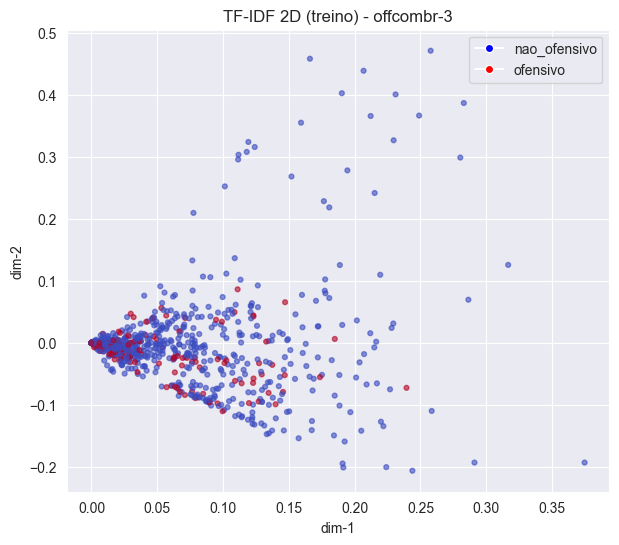

In [9]:
def build_tfidf(texts, max_features=MAX_FEATURES_TFIDF):
    """ Cria e ajusta um TfidfVectorizer somente com UNIGRAMAS (n_grams=1).
    - texts: array de textos (pré-processados) do conjunto de treino
    - max_features: limite superior de vocabulário (controle de sparsidade/tempo)
    Retorna:
      vec -> o vectorizer ajustado (fit) no treino
      X   -> a matriz TF-IDF esparsa de shape [n_docs, n_features]"""
    vec = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    X = vec.fit_transform(texts)
    return vec, X

def top_tokens_by_tfidf(vec, X, top_k=30):
    """ Calcula a importância média dos tokens no corpus de treino:
      - média da coluna TF-IDF (quanto maior, mais representativo no corpus)
    Retorna um DataFrame com os TOP-K tokens e seu TF-IDF médio."""
    mean_vals = X.mean(axis=0).A1
    idx = np.argsort(mean_vals)[::-1][:top_k]
    feats = np.array(vec.get_feature_names_out())[idx]
    vals = mean_vals[idx]
    return pd.DataFrame({"token": feats, "tfidf_mean": vals})

def token_distribution_pt(texts, n=2000):
    """ Faz uma amostra (até n textos) e tokeniza em PT para ver as palavras
    mais frequentes (apenas para INSPEÇÃO; não é a base do modelo)."""
    sample = texts if len(texts) <= n else random.sample(list(texts), n)
    toks = []
    for t in sample:
        toks.extend(word_tokenize(t, language='portuguese'))
    return pd.Series(toks).value_counts().head(30)

def sentence_distribution_pt(texts, n=2000):
    """ Mede a distribuição de número de sentenças por documento (amostra até n),
    usando sent_tokenize em PT. Mostra o comprimento dos textos."""
    sample = texts if len(texts) <= n else random.sample(list(texts), n)
    sent_lens = [len(sent_tokenize(t, language='portuguese')) for t in sample]
    return pd.Series(sent_lens).describe()

def plot_tfidf_2d(X, labels, title="TF-IDF 2D (treino)"):
    """ Reduz a matriz TF-IDF de alta dimensão para 2D e plota:
      - Se UMAP estiver disponível, usa UMAP (mais expressivo).
      - Caso contrário, usa TruncatedSVD (rápido e estável em TF-IDF).
    'labels' são as classes 0/1 para colorir os pontos."""
    if X.shape[1] < 2:
        print("Matriz TF-IDF tem menos de 2 dimensões após seleção de features.")
        return
    if HAS_UMAP:
        reducer = umap.UMAP(random_state=SEED, n_components=2)
        X2 = reducer.fit_transform(X)
    else:
        svd = TruncatedSVD(n_components=2, random_state=SEED)
        X2 = svd.fit_transform(X)

    plt.figure(figsize=(7,6))
    plt.scatter(X2[:,0], X2[:,1], c=labels, cmap="coolwarm", alpha=0.6, s=12)
    plt.title(title)
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    # Legenda simples: 0=nao_ofensivo, 1=ofensivo
    handles = [plt.Line2D([0],[0], marker='o', color='w', label='nao_ofensivo',
                          markerfacecolor='blue', markersize=6),
               plt.Line2D([0],[0], marker='o', color='w', label='ofensivo',
                          markerfacecolor='red', markersize=6)]
    plt.legend(handles=handles, loc="best")
    plt.show()

def plot_top_tokens_bar(df_top, top_n=20, title="Top tokens por TF-IDF médio"):
    """ Plota um gráfico de barras horizontal com os 'top_n' tokens de maior TF-IDF médio.
    - df_top: DataFrame com colunas ['token', 'tfidf_mean'] (saída de top_tokens_by_tfidf)
    - top_n: quantos tokens exibir"""
    # Seleciona os top_n (se df_top tiver < top_n, pega todos)
    df_show = df_top.head(top_n).copy()

    # Inverte a ordem para o barh (o maior em cima)
    df_show = df_show.iloc[::-1]

    plt.figure(figsize=(8, max(4, top_n * 0.35)))
    plt.barh(df_show["token"], df_show["tfidf_mean"])
    plt.title(title)
    plt.xlabel("TF-IDF médio")
    plt.ylabel("Token")
    plt.tight_layout()
    plt.show()

# Execução da exploração para cada variante (OFFCOMBR-2 e OFFCOMBR-3)
# Usa os textos PRÉ-PROCESSADOS do CONJUNTO DE TREINO (splits[cfg]["train_text"])
for cfg in CONFIGS:
    print(f"\n=== Exploração TF-IDF ({cfg}) ===")
    tr_texts = splits[cfg]["train_text"]    # Textos já pré-processados (tokenização, stopwords, stemming, unigramas)
    tr_y = splits[cfg]["train_y"]           # Rótulos 0/1

    # Vetorização TF-IDF no treino (define vocabulário e pesos)
    vec, Xtr = build_tfidf(tr_texts)

    # Top-K tokens por TF-IDF médio (importância média no corpus)
    df_top = top_tokens_by_tfidf(vec, Xtr, top_k=30)
    display(df_top)

    # Gráfico de barras com os 20 principais tokens por TF-IDF médio
    plot_top_tokens_bar(df_top, top_n=20, title=f"Top-20 TF-IDF médio – {cfg}")

    # Distribuição de tokens (amostra) com tokenização PT (diagnóstico)
    print("\nPalavras mais frequentes (tokenização PT - amostra):")
    print(token_distribution_pt(tr_texts).to_string())

    # Distribuição do número de sentenças por documento (amostra)
    print("\nDistribuição de sentenças (PT - amostra):")
    print(sentence_distribution_pt(tr_texts).to_string())

    # Visualização 2D do espaço TF-IDF do treino
    print("\nVisualização 2D do TF-IDF (treino):")
    plot_tfidf_2d(Xtr, tr_y, title=f"TF-IDF 2D (treino) - {cfg}")

## 4. Modelo Random Forest (TF‑IDF) + SHAP



=== Random Forest @ offcombr-2 ===
              precision    recall  f1-score   support

nao_ofensivo     0.8084    0.8133    0.8108       166
    ofensivo     0.6265    0.6190    0.6228        84

    accuracy                         0.7480       250
   macro avg     0.7174    0.7162    0.7168       250
weighted avg     0.7473    0.7480    0.7476       250

Matriz de confusão (linhas=verdadeiro, colunas=previsto):


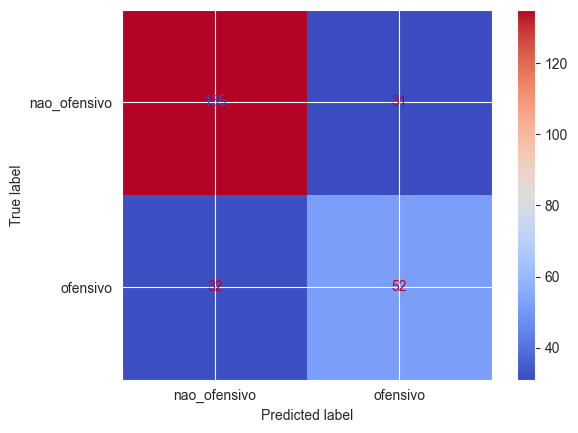


Instâncias mal classificadas (exibindo até 10): 63
- TRUE=0 PRED=1 | romariogtronaldogtzidanegtmessigtronaldinhogtcr
- TRUE=0 PRED=1 | prefere usar damiao vizeu comentarios
- TRUE=1 PRED=0 | mulher deita issoate feio filha lindaso
- TRUE=0 PRED=1 | provar irao cadeia
- TRUE=0 PRED=1 | concluiu ato concordouai estupro kkkkkkkkkkkkkkkk
- TRUE=1 PRED=0 | comunista defendendo democraciakkkkk vermelhinhos sao piada
- TRUE=1 PRED=0 | pec vidaaaa vida livre mamata esquerdalhaaaaaa kkkkkkkkkk
- TRUE=1 PRED=0 | sera hospedou mansao dedos punta del
- TRUE=0 PRED=1 | desordem regresso
- TRUE=1 PRED=0 | concordo carlos lavagem cerebral pra asnos

=== Random Forest @ offcombr-3 ===
              precision    recall  f1-score   support

nao_ofensivo     0.8342    0.9940    0.9071       167
    ofensivo     0.8750    0.1750    0.2917        40

    accuracy                         0.8357       207
   macro avg     0.8546    0.5845    0.5994       207
weighted avg     0.8421    0.8357    0.7882      

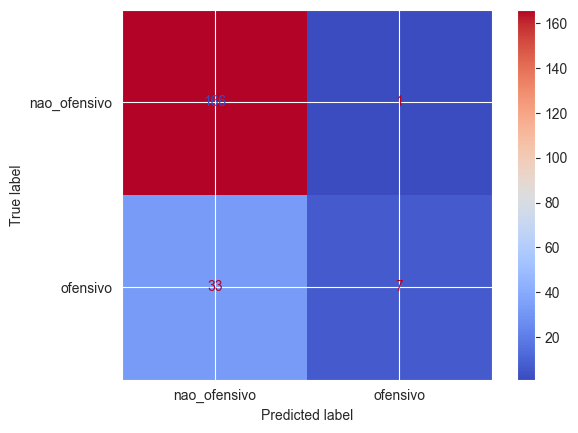


Instâncias mal classificadas (exibindo até 10): 34
- TRUE=1 PRED=0 | corrupta terrorista apresenta ameaca honesto povo uruguaio
- TRUE=1 PRED=0 | gentinha estao fedendo mortadela podre tomam banho
- TRUE=0 PRED=1 | boca mole bolso contas bancarias abarrotadas dolares sahfado
- TRUE=1 PRED=0 | cuidar bandida venda infirmacoes sensiveis brasil
- TRUE=1 PRED=0 | igual mamis prega indestrutivel kkkkkkkkkkk
- TRUE=1 PRED=0 | junior soares defequei juniorizinhos
- TRUE=1 PRED=0 | ja programa
- TRUE=1 PRED=0 | tipo idiota abestado voce
- TRUE=1 PRED=0 | ai senta boneca
- TRUE=1 PRED=0 | adinaldo kkkkkkkkkkkk defe cando mortadela


In [10]:
def train_eval_rf(cfg, n_estimators=600, max_depth=None):
    tr_texts, tr_y = splits[cfg]["train_text"], splits[cfg]["train_y"]
    te_texts, te_y = splits[cfg]["test_text"], splits[cfg]["test_y"]

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,1), max_features=MAX_FEATURES_TFIDF)),
        ("rf", RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                     class_weight="balanced_subsample", n_jobs=-1, random_state=SEED))
    ])
    pipe.fit(tr_texts, tr_y)

    # predictions and probabilities
    te_pred = pipe.predict(te_texts)
    acc = accuracy_score(te_y, te_pred)
    p, r, f1, _ = precision_recall_fscore_support(te_y, te_pred, average="macro", zero_division=0)

    print(f"\n=== Random Forest @ {cfg} ===")
    print(classification_report(te_y, te_pred, digits=4, target_names=["nao_ofensivo","ofensivo"]))
    print("Matriz de confusão (linhas=verdadeiro, colunas=previsto):")
    cm = confusion_matrix(te_y, te_pred, labels=[0,1])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["nao_ofensivo","ofensivo"])
    cm_display.plot(cmap="coolwarm", values_format="d")
    plt.show()

    # misclassified
    mis_idx = np.where(te_pred != te_y)[0].tolist()
    print(f"\nInstâncias mal classificadas (exibindo até 10): {len(mis_idx)}")
    for i in mis_idx[:10]:
        print(f"- TRUE={te_y[i]} PRED={te_pred[i]} | {te_texts[i][:200]}")

    return pipe, {"accuracy":acc,"precision_macro":p,"recall_macro":r,"f1_macro":f1}

rf_pipes = {}
rf_metrics = {}
for cfg in CONFIGS:
    pipe, mets = train_eval_rf(cfg)
    rf_pipes[cfg] = pipe
    rf_metrics[cfg] = mets

### 4.1 SHAP no RF (global e local)



=== SHAP para RF (offcombr-2) ===


100%|===================| 399/400 [05:21<00:00]        

[debug] n_vec=3206 | n_shap=3206 | n_common=3206 | X_eval=(200, 3206)


,token,mean_abs_shap
0,curiosidade,0.013634
1,cupim,0.013634
2,cortando,0.011955
3,cortam,0.011955
4,educando,0.010775
5,eficiente,0.010775
6,vasco,0.009975
7,vascainos,0.009975
8,mendespsdb,0.007666
9,mendigos,0.007666


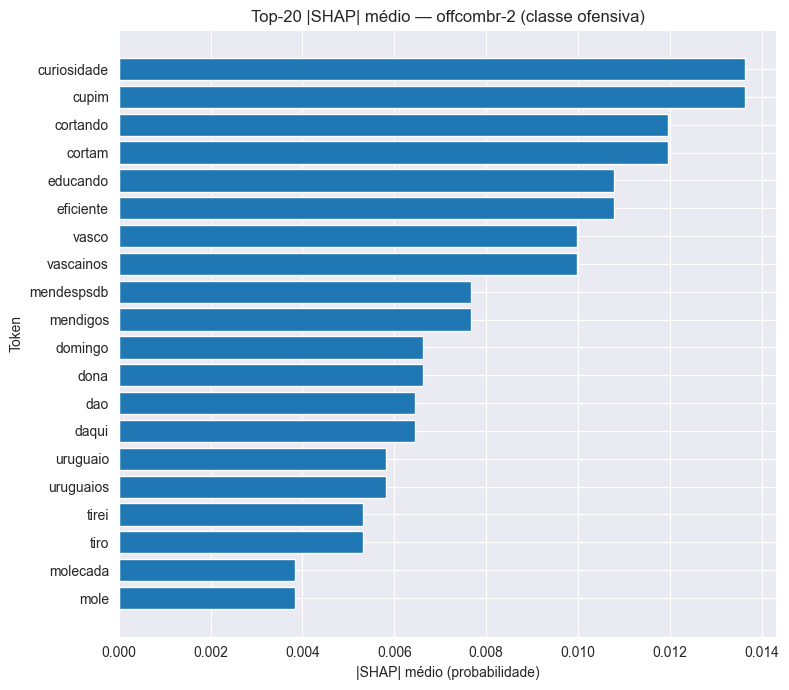

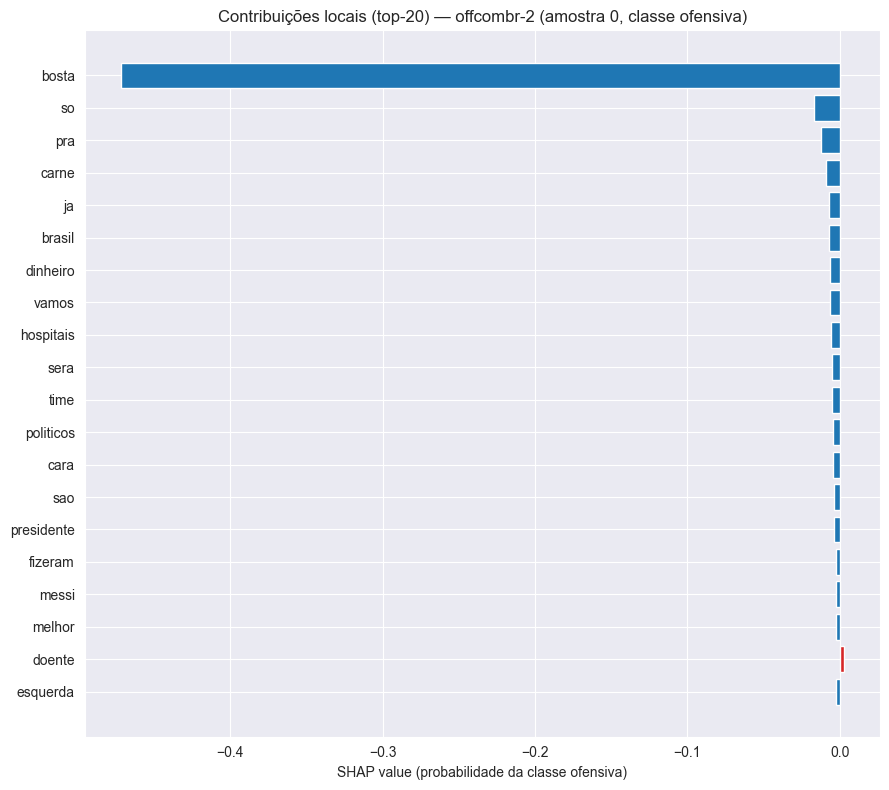


=== SHAP para RF (offcombr-3) ===


100%|===================| 399/400 [03:51<00:00]        

[debug] n_vec=2793 | n_shap=2793 | n_common=2793 | X_eval=(200, 2793)


,token,mean_abs_shap
0,corporativos,0.005749
1,corporativo,0.005749
2,edmond,0.004867
3,edsonda,0.004867
4,dobro,0.004615
5,dobrarao,0.004615
6,demente,0.003969
7,delesisso,0.003969
8,cruzeiro,0.003521
9,cruz,0.003521


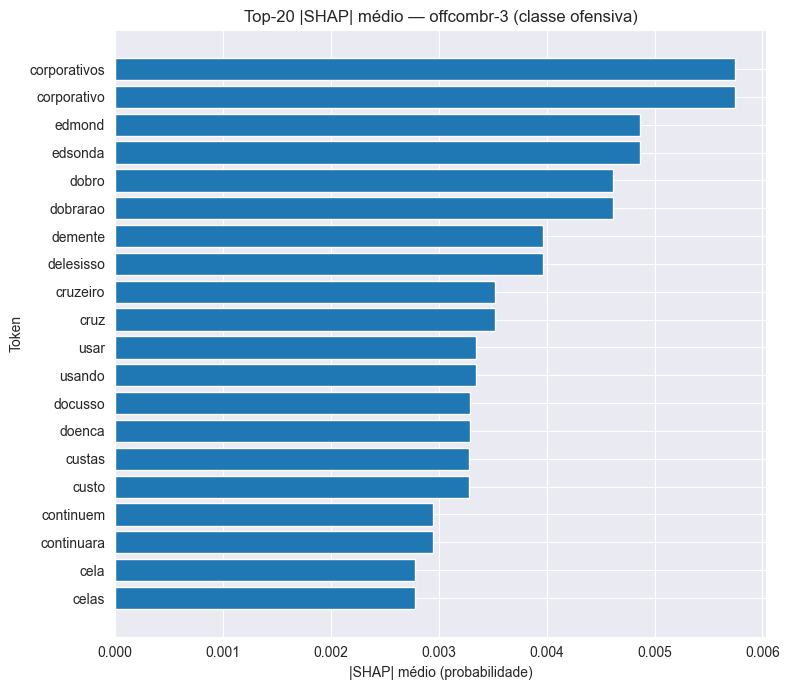

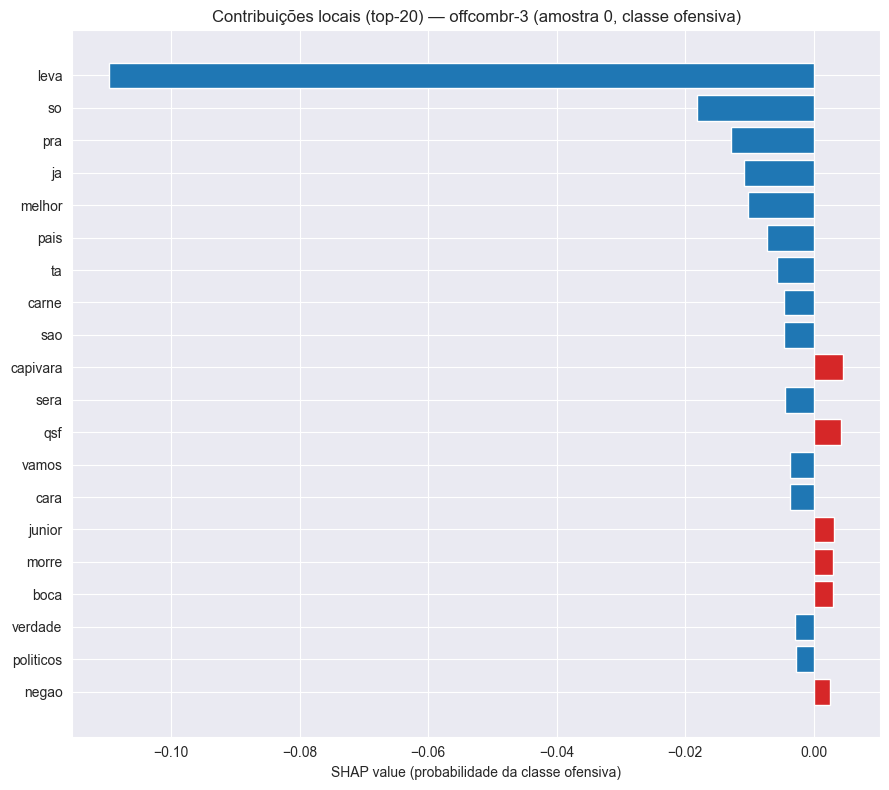

In [11]:
def shap_rf_global_local(pipe, cfg, max_bg=300, max_eval=200, top_k=20, show_bar=True, show_local=True, verbose_once=True):
    """ SHAP para RF (TF-IDF) com alinhamento robusto.
    - Global: top-|SHAP| médio (classe positiva) + barh
    - Local: top-|SHAP| da 1ª amostra do conjunto de avaliação + barh manual (sinal e magnitude)"""
    vec = pipe.named_steps["tfidf"]
    rf  = pipe.named_steps["rf"]
    tr_texts = splits[cfg]["train_text"]
    te_texts = splits[cfg]["test_text"]
    rng = np.random.default_rng(SEED)

    # ----- Background (treino) e Avaliação (teste) -----
    bg_idx = rng.choice(len(tr_texts), size=min(max_bg, len(tr_texts)), replace=False)
    ev_idx = rng.choice(len(te_texts), size=min(max_eval, len(te_texts)), replace=False)
    X_bg   = vec.transform(tr_texts[bg_idx]).toarray()
    X_eval = vec.transform(te_texts[ev_idx]).toarray()
    feature_names_full = np.asarray(vec.get_feature_names_out())
    n_vec = feature_names_full.shape[0]
    assert X_bg.shape[1] == n_vec and X_eval.shape[1] == n_vec, "Desalinhamento TF-IDF vs nomes."

    # ----- Explainer (interventional + probability) -----
    explainer = shap.TreeExplainer(rf, data=X_bg, model_output="probability", feature_perturbation="interventional")
    sv = explainer.shap_values(X_eval)

    # Converte p/ ndarray
    shap_pos_arr = np.asarray(sv[1] if isinstance(sv, list) else sv)    # (n_eval, n_features) idealmente
    if shap_pos_arr.ndim == 1:
        shap_pos_arr = shap_pos_arr.reshape(1, -1)
    n_shap = shap_pos_arr.shape[1]
    n_common = min(n_vec, n_shap)
    if verbose_once:
        print(f"[debug] n_vec={n_vec} | n_shap={n_shap} | n_common={n_common} | X_eval={X_eval.shape}")
    feature_names = feature_names_full[:n_common]
    shap_pos_arr  = shap_pos_arr[:, :n_common]

    # ===================== GLOBAL =====================
    mean_abs = np.mean(np.abs(shap_pos_arr), axis=0).ravel()[:n_common]
    k_global = min(top_k, n_common)
    order = np.argsort(mean_abs)[::-1][:k_global].astype(int)
    feats = feature_names[order]; vals = mean_abs[order]
    df_top = pd.DataFrame({"token": feats.tolist(), "mean_abs_shap": vals.tolist()})
    display(df_top)
    if show_bar:
        df_show = df_top.iloc[::-1]
        plt.figure(figsize=(8, max(4, len(df_show) * 0.35)))
        plt.barh(df_show["token"], df_show["mean_abs_shap"])
        plt.title(f"Top-{k_global} |SHAP| médio — {cfg} (classe ofensiva)")
        plt.xlabel("|SHAP| médio (probabilidade)")
        plt.ylabel("Token")
        plt.tight_layout()
        plt.show()

    # ===================== LOCAL (barh manual) =====================
    if show_local and shap_pos_arr.shape[0] > 0:
        # Contribuições da 1ª amostra
        local_full = shap_pos_arr[0, :n_common]

        # Normalização: força cada elemento a ser escalar float
        def _to_scalar(x):
            arr = np.asarray(x)
            return float(arr.reshape(-1)[0])    # Pega o primeiro escalar caso venha vetor/array

        local_full = np.array([_to_scalar(v) for v in local_full], dtype=float) # (m_names,)
        k_local = min(top_k, n_common)
        idx_loc = np.argsort(np.abs(local_full))[::-1][:k_local].astype(int)
        local_vals  = local_full[idx_loc]; local_names = feature_names[idx_loc]

        # Plot barh com sinal (positivo empurra para ofensivo; negativo contra)
        order_plot = np.argsort(np.abs(local_vals))[::-1]
        vals_plot  = local_vals[order_plot]
        names_plot = local_names[order_plot]
        plt.figure(figsize=(9, max(4, k_local * 0.4)))
        colors = ["tab:red" if v > 0 else "tab:blue" for v in vals_plot]
        plt.barh(range(len(vals_plot)), vals_plot, color=colors)
        plt.yticks(range(len(vals_plot)), names_plot)
        plt.title(f"Contribuições locais (top-{k_local}) — {cfg} (amostra 0, classe ofensiva)")
        plt.xlabel("SHAP value (probabilidade da classe ofensiva)")
        plt.gca().invert_yaxis()    # maior no topo
        plt.tight_layout()
        plt.show()

for cfg in CONFIGS:
    print(f"\n=== SHAP para RF ({cfg}) ===")
    shap_rf_global_local(rf_pipes[cfg], cfg)

## 4.2 Logistic Regression ##

In [12]:
lr_pipes = {}
lr_metrics = {}

for cfg in CONFIGS:
    print(f"\n=== Logistic Regression @ {cfg} (char+word TF-IDF) ===")
    tr_texts = list(splits[cfg]["train_text"])  # usa texto pré-processado (n-grams de palavras)
    te_texts = list(splits[cfg]["test_text"])
    tr_y     = np.asarray(splits[cfg]["train_y"])
    te_y     = np.asarray(splits[cfg]["test_y"])

    # Vetorizador híbrido: palavra (1–2) + caractere (3–5)
    # Fazemos dois vetores e concatenamos via FeatureUnion-like simples por Pipeline separado
    word_vec = TfidfVectorizer(max_features=MAX_FEATURES_TFIDF, ngram_range=(1,2), analyzer="word")
    char_vec = TfidfVectorizer(max_features=MAX_FEATURES_TFIDF, ngram_range=(3,5), analyzer="char")

    # Ajusta e concatena manualmente (para simplicidade e transparência)
    Xw_tr = word_vec.fit_transform(tr_texts)
    Xc_tr = char_vec.fit_transform(tr_texts)
    from scipy.sparse import hstack
    X_tr = hstack([Xw_tr, Xc_tr])

    Xw_te = word_vec.transform(te_texts)
    Xc_te = char_vec.transform(te_texts)
    X_te = hstack([Xw_te, Xc_te])

    clf = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
    clf.fit(X_tr, tr_y)

    proba = clf.predict_proba(X_te)[:,1]
    y_pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(te_y, y_pred)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(te_y, y_pred, average="macro", zero_division=0)
    ap = average_precision_score(te_y, proba)

    print(f"Accuracy={acc:.4f} | Precision_macro={p_m:.4f} | Recall_macro={r_m:.4f} | F1_macro={f1_m:.4f} | AP={ap:.4f}")

    # Armazena componentes para uso na seção 7
    lr_pipes[cfg] = {"word_vec": word_vec, "char_vec": char_vec, "clf": clf}
    lr_metrics[cfg] = {"accuracy":acc, "precision_macro":p_m, "recall_macro":r_m, "f1_macro":f1_m, "AP":ap}


=== Logistic Regression @ offcombr-2 (char+word TF-IDF) ===
Accuracy=0.8040 | Precision_macro=0.7904 | Recall_macro=0.7554 | F1_macro=0.7675 | AP=0.8218

=== Logistic Regression @ offcombr-3 (char+word TF-IDF) ===
Accuracy=0.8696 | Precision_macro=0.8572 | Recall_macro=0.6910 | F1_macro=0.7332 | AP=0.6927


## 5. BERTimbau (Transformer) + SHAP


torch: 2.9.0+cu126 | cuda disponível: True
GPU: NVIDIA GeForce RTX 3080 Laptop GPU | cc: (8, 6)

=== Fine-tuning BERTimbau (offcombr-2) ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.572800,0.484169,0.772000,0.748379,0.722461,0.731593
2,0.418600,0.457724,0.780000,0.754053,0.746127,0.749686
3,0.307400,0.461031,0.796000,0.771831,0.784639,0.776985



=== Avaliação BERTimbau (offcombr-2) ===
eval_loss = 0.4610310196876526
eval_accuracy = 0.796
eval_precision_macro = 0.7718306965276351
eval_recall_macro = 0.7846385542168675
eval_f1_macro = 0.7769848349687778
eval_runtime = 31.1888
eval_samples_per_second = 8.016
eval_steps_per_second = 0.257
epoch = 3.0

Classification report:
              precision    recall  f1-score   support

nao_ofensivo     0.8662    0.8193    0.8421       166
    ofensivo     0.6774    0.7500    0.7119        84

    accuracy                         0.7960       250
   macro avg     0.7718    0.7846    0.7770       250
weighted avg     0.8028    0.7960    0.7983       250

Matriz de confusão (linhas=verdadeiro, colunas=previsto):


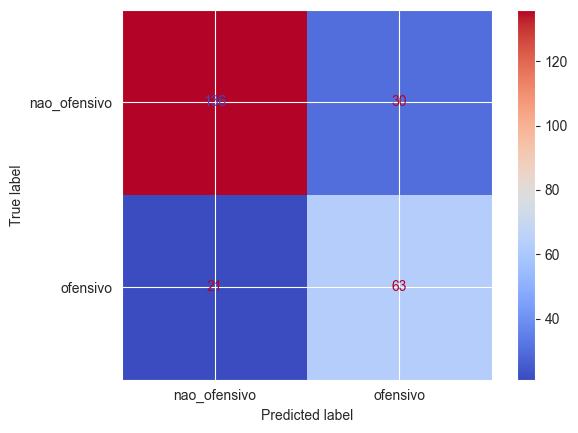


Instâncias mal classificadas (exibindo até 10): 51
- TRUE=0 PRED=1 | romariogtronaldogtzidanegtmessigtronaldinhogtcr
- TRUE=0 PRED=1 | mpf interesses tucanos pmdbistas
- TRUE=1 PRED=0 | comunista defendendo democraciakkkkk vermelhinhos sao piada
- TRUE=1 PRED=0 | sera hospedou mansao dedos punta del
- TRUE=0 PRED=1 | mano boaangelim volte pro video game rapaz cara fala messi ja eleito melhor time acaso pele considerado cosmos carreira existe provar clube seguindo logica iniesta bosta voce
- TRUE=1 PRED=0 | concordo carlos lavagem cerebral pra asnos
- TRUE=1 PRED=0 | 
- TRUE=0 PRED=1 | fafa alunos zuados escola paga revoltadinho internet
- TRUE=1 PRED=0 | 
- TRUE=0 PRED=1 | correto adriano adryan melhor cirino gabriel fernandinho

=== Fine-tuning BERTimbau (offcombr-3) ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.526200,0.420995,0.806763,0.403382,0.500000,0.446524
2,0.358800,0.344031,0.869565,0.831522,0.710030,0.747253
3,0.250300,0.346313,0.874396,0.815819,0.751048,0.776495



=== Avaliação BERTimbau (offcombr-3) ===
eval_loss = 0.3463131785392761
eval_accuracy = 0.8743961352657005
eval_precision_macro = 0.815819209039548
eval_recall_macro = 0.7510479041916167
eval_f1_macro = 0.7764950166112956
eval_runtime = 33.5053
eval_samples_per_second = 6.178
eval_steps_per_second = 0.209
epoch = 3.0

Classification report:
              precision    recall  f1-score   support

nao_ofensivo     0.8983    0.9521    0.9244       167
    ofensivo     0.7333    0.5500    0.6286        40

    accuracy                         0.8744       207
   macro avg     0.8158    0.7510    0.7765       207
weighted avg     0.8664    0.8744    0.8673       207

Matriz de confusão (linhas=verdadeiro, colunas=previsto):


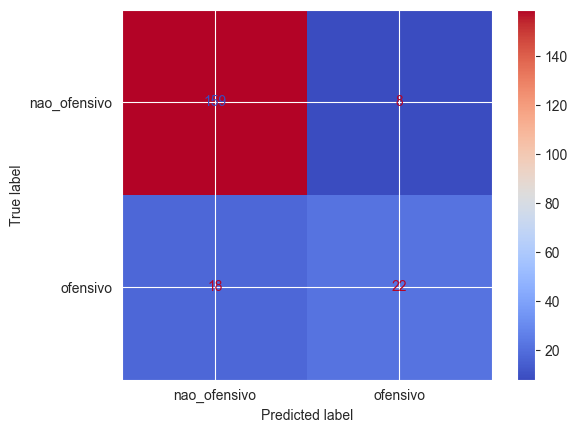


Instâncias mal classificadas (exibindo até 10): 26
- TRUE=1 PRED=0 | corrupta terrorista apresenta ameaca honesto povo uruguaio
- TRUE=0 PRED=1 | junta pontas fla cueva
- TRUE=1 PRED=0 | cuidar bandida venda infirmacoes sensiveis brasil
- TRUE=1 PRED=0 | retocar maquiagem tricolete frufru come ninguem comido
- TRUE=0 PRED=1 | muie drome cuie brinca fiuvicocuidado
- TRUE=1 PRED=0 | junior soares defequei juniorizinhos
- TRUE=1 PRED=0 | ja programa
- TRUE=0 PRED=1 | lazarentuuuuu
- TRUE=1 PRED=0 | kkkkk ladrao merece morte
- TRUE=1 PRED=0 | so numero dislike coment inutil moral assimpalhaco


In [13]:
# --- GPU/precisão: configurações
USE_GPU = torch.cuda.is_available()

# Ampere+ suporta bf16; caso contrário, fp16
BF16_OK = USE_GPU and torch.cuda.get_device_capability(0)[0] >= 8
FP16_OK = USE_GPU and not BF16_OK

if USE_GPU:
    torch.set_float32_matmul_precision("high")
    torch.backends.cudnn.benchmark = True

def make_train_args(out_dir, *, epochs=3, bsz_train=16, bsz_eval=32, lr=2e-5, seed=42, warmup_ratio=0.1):
    """ Helper para criar TrainingArguments com os *flags* corretos para GPU/CPU."""
    return TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=bsz_train,
        per_device_eval_batch_size=bsz_eval,
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        warmup_ratio=warmup_ratio,
        weight_decay=0.01,
        seed=seed,
        report_to="none",
        fp16=FP16_OK,
        bf16=BF16_OK,
        gradient_accumulation_steps=1,
        dataloader_num_workers=2,
        dataloader_pin_memory=USE_GPU,
    )

def tokenize_ds(tokenizer, texts, labels, max_length=MAX_LEN_BERT):
    """ Tokeniza sem padding fixo (padding dinâmico será feito pelo DataCollator)."""
    enc = tokenizer(list(texts), truncation=True, padding=False, max_length=max_length)
    enc["labels"] = list(labels)
    return enc

def run_bertimbau(
    cfg,
    model_name="neuralmind/bert-base-portuguese-cased",
    lr=LR_BERT, epochs=EPOCHS_BERT,
    bsz_train=BATCH_TRAIN, bsz_eval=BATCH_EVAL,
    max_length=MAX_LEN_BERT
):
    # --- Dados (mesmo split da Seção 2.1)
    tr_texts, tr_y = splits[cfg]["train_text"], splits[cfg]["train_y"]
    te_texts, te_y = splits[cfg]["test_text"],  splits[cfg]["test_y"]

    # --- Tokenizer + datasets HF
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_enc = tokenize_ds(tokenizer, tr_texts, tr_y, max_length=max_length)
    test_enc  = tokenize_ds(tokenizer, te_texts, te_y,  max_length=max_length)

    train_ds = hfds.Dataset.from_dict(train_enc)
    test_ds  = hfds.Dataset.from_dict(test_enc)

    # Padding dinâmico, múltiplo de 8 acelera GPU
    collator = DataCollatorWithPadding(
        tokenizer=tokenizer,
        pad_to_multiple_of=8 if USE_GPU else None
    )

    # --- Modelo
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # --- Args de treino (com fp16/bf16 quando possível)
    args = make_train_args(
        out_dir=os.path.join(ARTIFACTS_DIR, f"hf_{model_name.split('/')[-1]}_{cfg}"),
        epochs=epochs, bsz_train=bsz_train, bsz_eval=bsz_eval, lr=lr, seed=SEED
    )

    # --- Métricas
    metric_acc = evaluate.load("accuracy")
    metric_f1  = evaluate.load("f1")
    metric_pr  = evaluate.load("precision")
    metric_rc  = evaluate.load("recall")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy":  metric_acc.compute(predictions=preds, references=labels)["accuracy"],
            "precision_macro": metric_pr.compute(predictions=preds, references=labels, average="macro")["precision"],
            "recall_macro":    metric_rc.compute(predictions=preds, references=labels, average="macro")["recall"],
            "f1_macro":        metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        }

    # --- Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    # --- Treino + avaliação
    trainer.train()
    metrics = trainer.evaluate()
    print(f"\n=== Avaliação BERTimbau ({cfg}) ===")
    for k, v in metrics.items():
        print(k, "=", v)

    # --- Inferência no teste para relatório/CM/erros
    raw = trainer.predict(test_ds)
    preds = np.argmax(raw.predictions, axis=-1)

    print("\nClassification report:")
    print(classification_report(te_y, preds, digits=4, target_names=["nao_ofensivo","ofensivo"]))
    print("Matriz de confusão (linhas=verdadeiro, colunas=previsto):")
    cm = confusion_matrix(te_y, preds, labels=[0,1])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["nao_ofensivo","ofensivo"])
    cm_display.plot(cmap="coolwarm", values_format="d")
    plt.show()

    mis_idx = np.where(preds != te_y)[0].tolist()
    print(f"\nInstâncias mal classificadas (exibindo até 10): {len(mis_idx)}")
    for i in mis_idx[:10]:
        print(f"- TRUE={te_y[i]} PRED={preds[i]} | {te_texts[i][:200]}")

    return tokenizer, model

# --------------------------
# Execução (OFFCOMBR-2/3)
# --------------------------
print("torch:", torch.__version__, "| cuda disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("GPU:", torch.cuda.get_device_name(0), "| cc:", torch.cuda.get_device_capability(0))
    except Exception:
        pass

bert_tok = {}
bert_model = {}
for cfg in CONFIGS:
    print(f"\n=== Fine-tuning BERTimbau ({cfg}) ===")
    tok, mdl = run_bertimbau(cfg)
    bert_tok[cfg] = tok
    bert_model[cfg] = mdl

### 5.1 SHAP no BERTimbau (masker de texto)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== SHAP: BERTimbau (offcombr-2) ===
Using 250 test texts from splits[offcombr-2]['test_text'].
Running SHAP on 100 texts...


PartitionExplainer explainer: 101it [02:30,  1.51s/it]                         


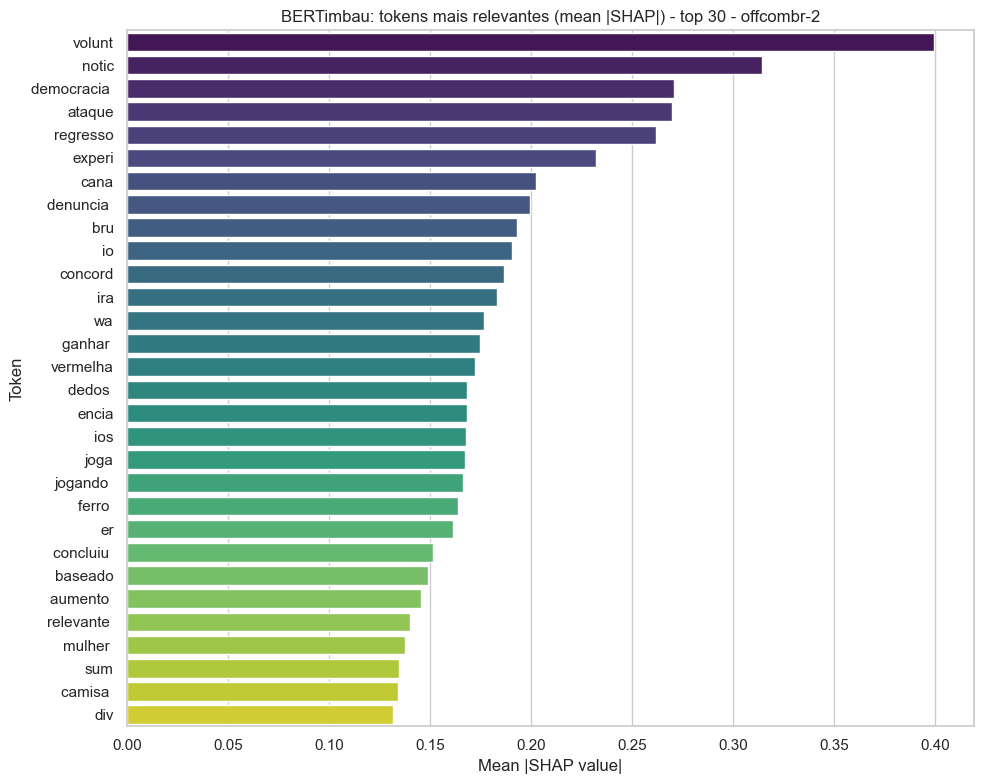

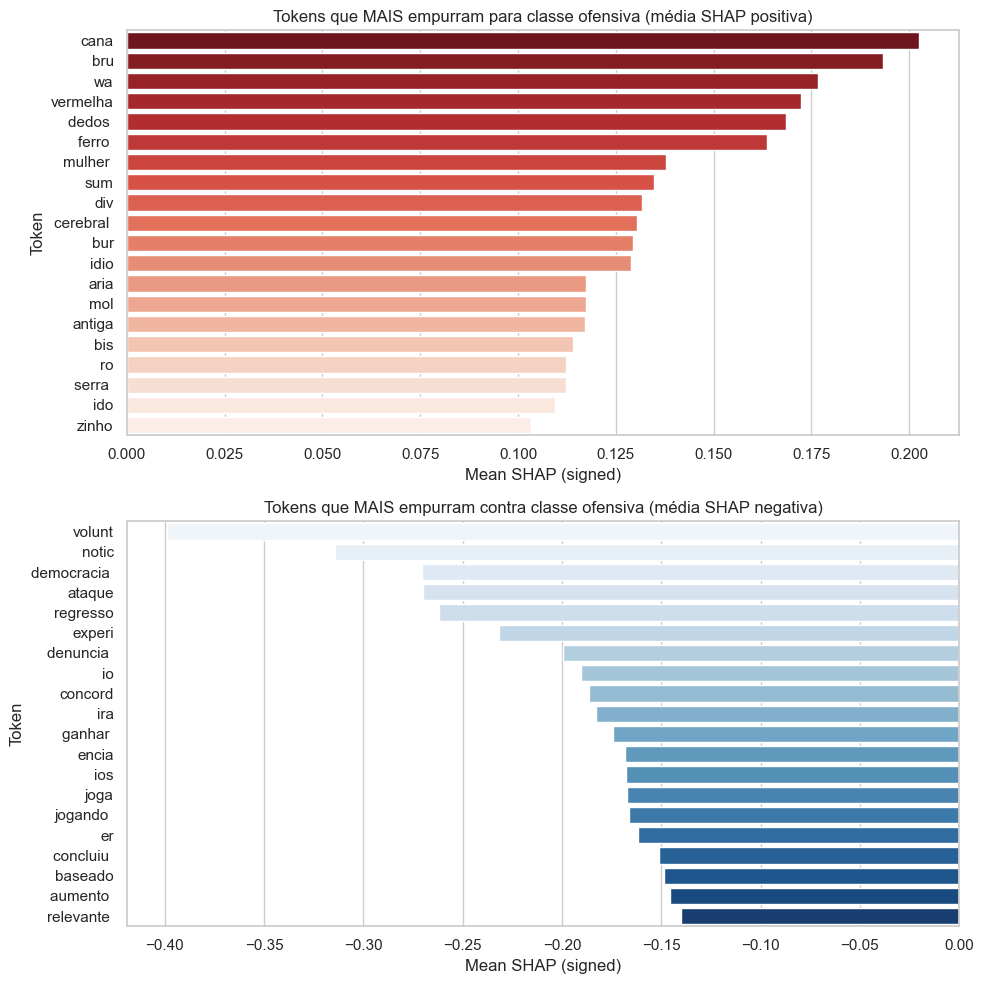

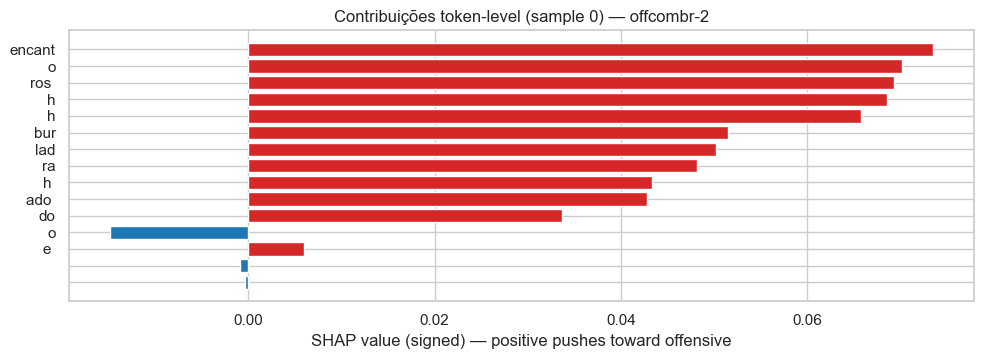

Sample 0 text (preprocessed): ohhh doe burros encantado ladrao


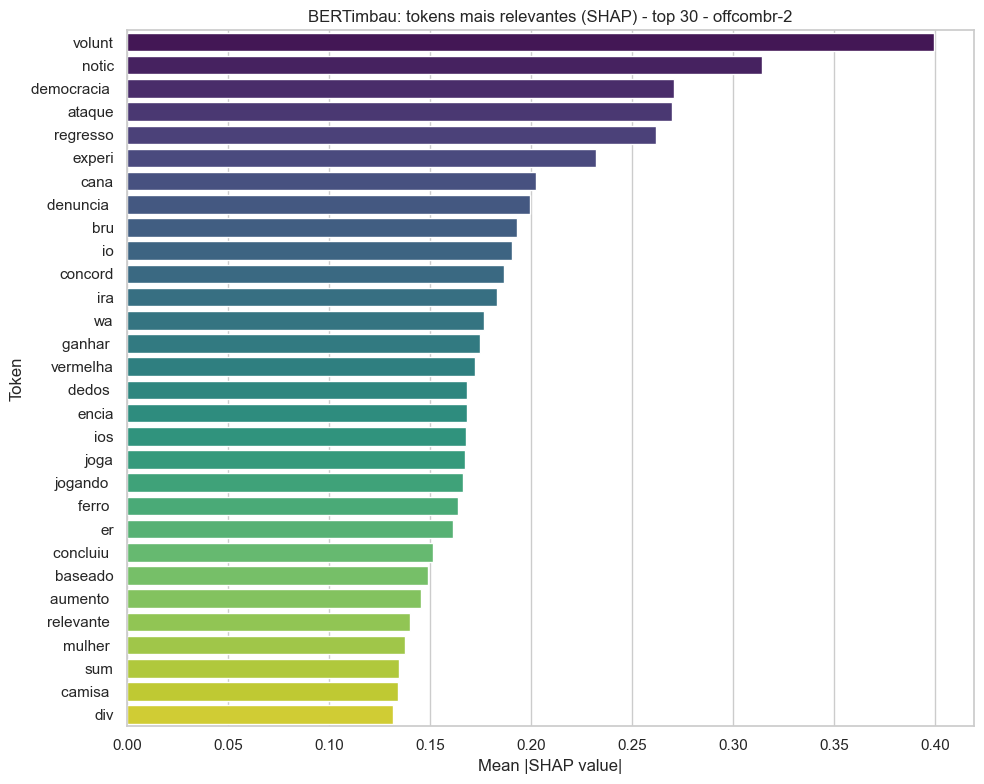

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== SHAP: BERTimbau (offcombr-3) ===
Using 207 test texts from splits[offcombr-3]['test_text'].
Running SHAP on 100 texts...


PartitionExplainer explainer: 101it [02:13,  1.48s/it]                         


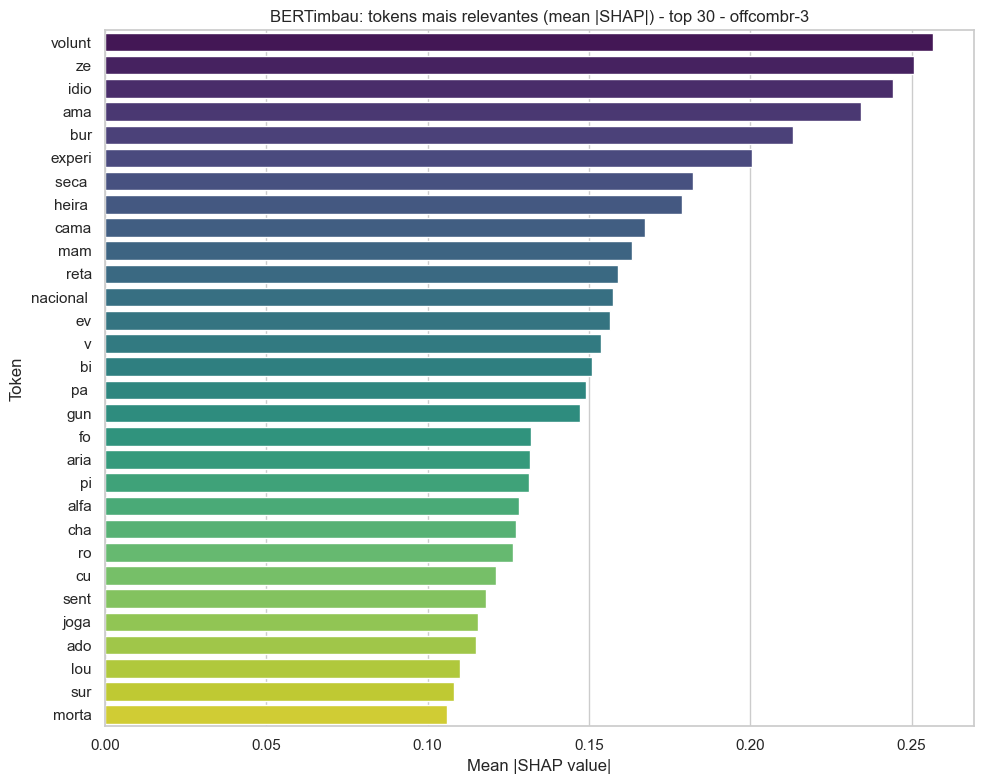

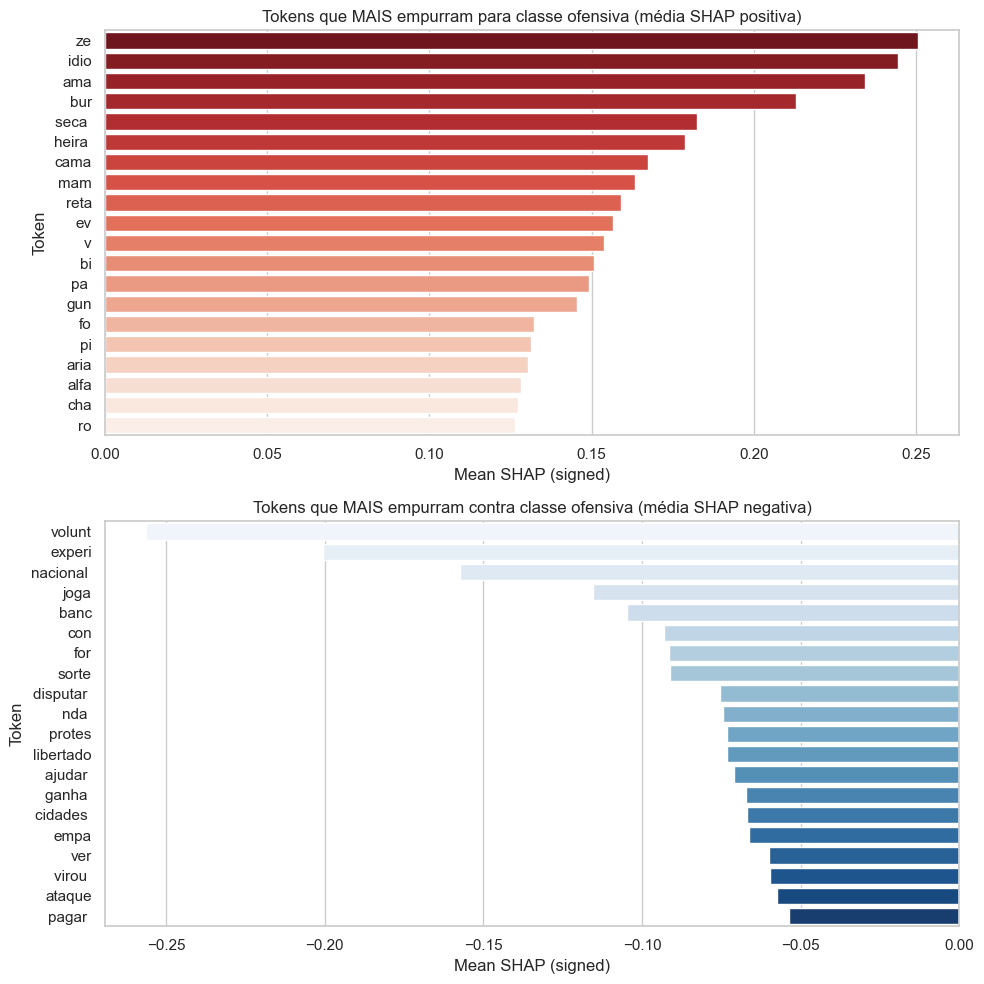

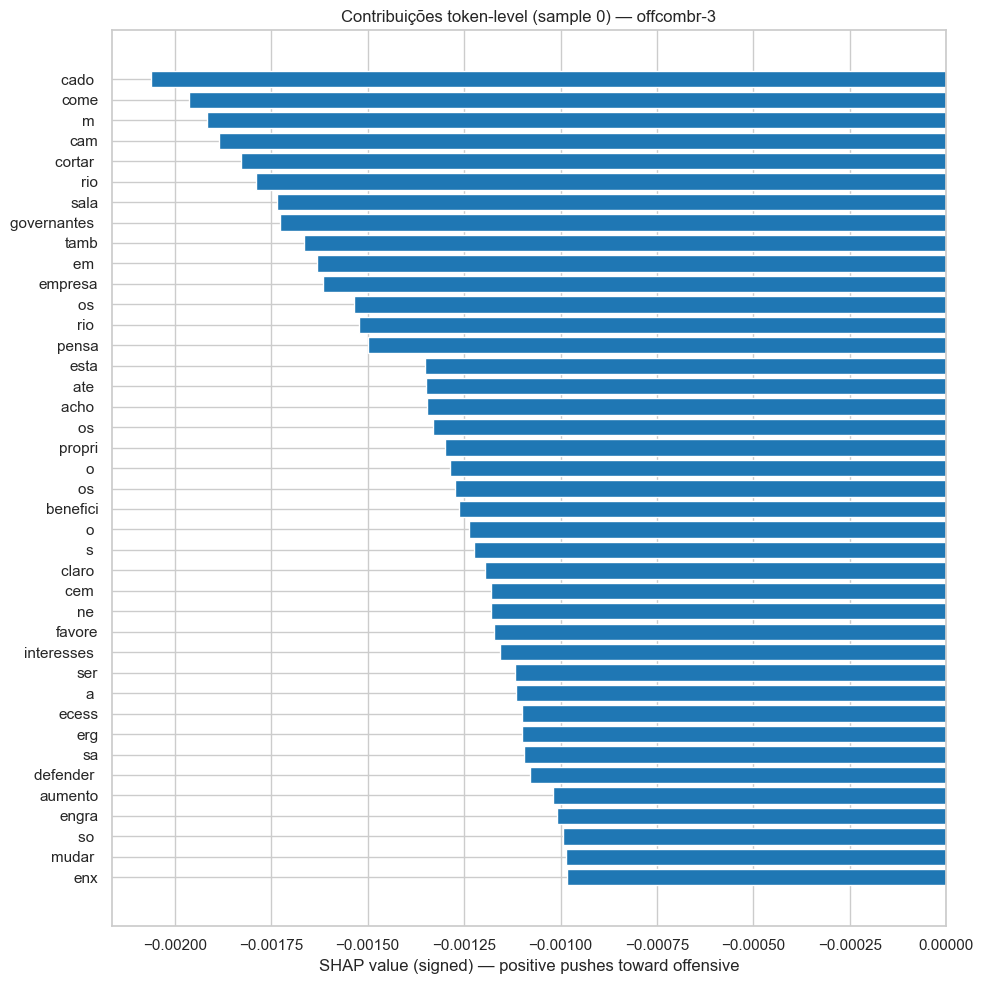

Sample 0 text (preprocessed): acho engracado governantes pensam cortar regalias beneficios desnecessarios favorecem sera ne claro ate enxergar sao estao defender proprios interesses empresario casso tambem comecamos tomar atitude mudar roubalheira pais tendencia so piorar povo dinheiro investimentos aumentos salario


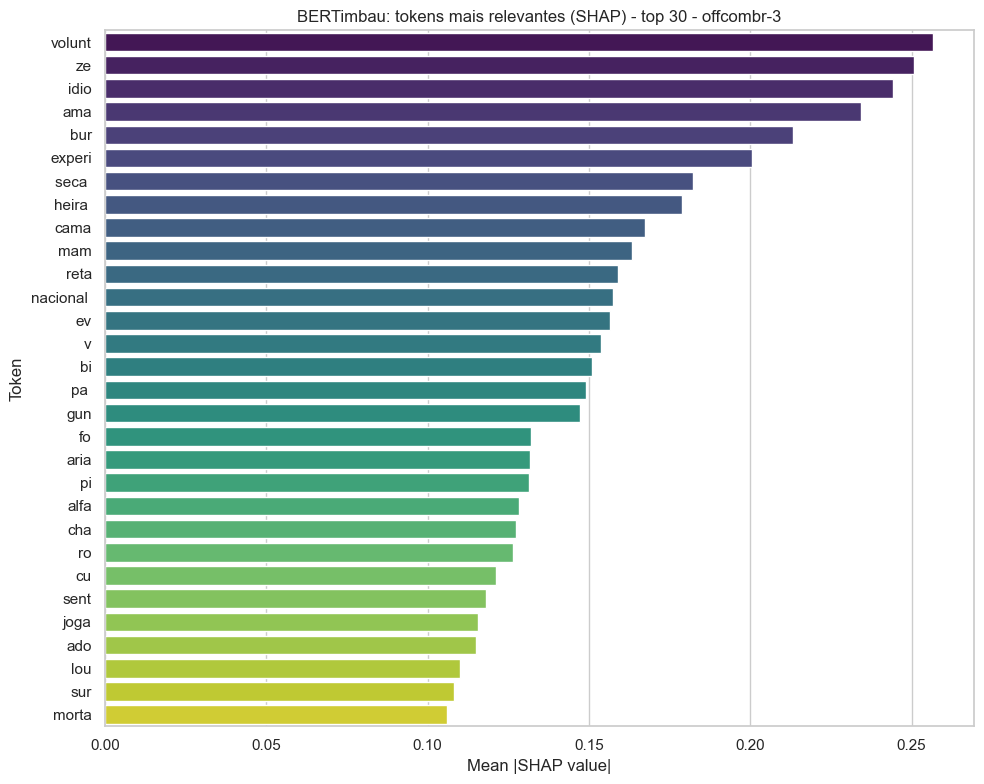

In [14]:
# --------------------------
# SHAP: BERTimbau (uses splits, bert_tok, bert_model)
# --------------------------
sns.set(style="whitegrid", font_scale=1.0)
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("./outputs/shap", exist_ok=True)

def make_predict_proba_fn(tokenizer, model, device):
    model.to(device)
    model.eval()
    def predict_proba(texts, batch_size=16):
        preds = []
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(list(batch), padding=True, truncation=True, return_tensors="pt")
                enc = {k: v.to(device) for k, v in enc.items()}
                out = model(**enc).logits
                probs = torch.softmax(out, dim=-1)[:, 1].detach().cpu().numpy()
                preds.append(probs)
        if len(preds) == 0:
            return np.array([])
        return np.concatenate(preds, axis=0)
    return predict_proba

for cfg in CONFIGS:
    try:
        print(f"\n=== SHAP: BERTimbau ({cfg}) ===")

        # Use test texts from your splits (already preprocessed strings used for training)
        test_texts = list(splits[cfg]["test_text"])
        if len(test_texts) == 0:
            print(f"No test texts for {cfg}, skipping SHAP.")
            continue
        print(f"Using {len(test_texts)} test texts from splits[{cfg}]['test_text'].")

        # Get tokenizer and model from the fine-tuning step
        tokenizer_bert = bert_tok[cfg]
        model_bert = bert_model[cfg]

        # Prepare predict_proba function bound to this tokenizer+model
        predict_proba = make_predict_proba_fn(tokenizer_bert, model_bert, device)

        # SHAP explainer setup (Text masker + model wrapper)
        masker = shap.maskers.Text(tokenizer_bert)
        explainer = shap.Explainer(predict_proba, masker)

        # Use a manageable subset for SHAP (adjust size to resources)
        subset = test_texts[:100] if len(test_texts) > 100 else test_texts
        print(f"Running SHAP on {len(subset)} texts...")
        shap_explanations = explainer(subset)

        # ---- Aggregate SHAP values per token (absolute mean) ----
        tokens_list = []
        signed_tokens = []  # keep signed values for class direction
        for ex in shap_explanations:
            toks = ex.data
            vals = ex.values
            # ex.values can be shape (n_tokens,) or (n_outputs, n_tokens). For probability explainer we expect (n_tokens,)
            if vals.ndim == 2:
                # if returned as (1, n_tokens)
                vals = vals[0]
            for t, v in zip(toks, vals):
                if t in tokenizer_bert.all_special_tokens:
                    continue
                tokens_list.append({"token": t, "abs_shap": abs(float(v))})
                signed_tokens.append({"token": t, "signed_shap": float(v)})

        df_shap_tokens = pd.DataFrame(tokens_list)
        df_signed = pd.DataFrame(signed_tokens)

        if df_shap_tokens.empty or df_signed.empty:
            raise RuntimeError("Nenhum token válido encontrado para agregação SHAP.")

        # Global importance by mean absolute SHAP
        df_token_summary = df_shap_tokens.groupby("token")["abs_shap"].mean().reset_index()
        df_token_summary = df_token_summary.sort_values("abs_shap", ascending=False)

        # Token-level signed mean (positive -> pushes toward offensive)
        df_token_signed = df_signed.groupby("token")["signed_shap"].mean().reset_index()
        df_token_signed = df_token_signed.sort_values("signed_shap", ascending=False)

        # ---- Plot 1: Global importance (mean |SHAP|) inline ----
        plt.figure(figsize=(10, 8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"BERTimbau: tokens mais relevantes (mean |SHAP|) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

        # ---- Plot 2: Token-level signed importance (direction for offensive class) inline ----
        # Show top tokens that most push toward offensive (positive) and most push against (negative)
        top_pos = df_token_signed.sort_values("signed_shap", ascending=False).head(20)
        top_neg = df_token_signed.sort_values("signed_shap", ascending=True).head(20)

        plt.figure(figsize=(10, 10))
        plt.subplot(2,1,1)
        sns.barplot(data=top_pos, x="signed_shap", y="token", palette="Reds_r")
        plt.title("Tokens que MAIS empurram para classe ofensiva (média SHAP positiva)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.subplot(2,1,2)
        sns.barplot(data=top_neg, x="signed_shap", y="token", palette="Blues")
        plt.title("Tokens que MAIS empurram contra classe ofensiva (média SHAP negativa)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.tight_layout()
        plt.show()

        # ---- Plot 3: Per-sample token-level contributions (first sample of subset) inline ----
        # Visualize contributions for a single example: token names and signed SHAP values
        if len(shap_explanations) > 0:
            ex0 = shap_explanations[0]
            toks0 = ex0.data
            vals0 = ex0.values
            if vals0.ndim == 2:
                vals0 = vals0[0]
            token_vals = [(t, float(v)) for t, v in zip(toks0, vals0) if t not in tokenizer_bert.all_special_tokens]
            if token_vals:
                names = [t for t, _ in token_vals]
                vals = np.array([v for _, v in token_vals], dtype=float)
                # Order by absolute contribution
                order = np.argsort(np.abs(vals))[::-1][:40]  # show up to 40 most important tokens
                vals_plot = vals[order]
                names_plot = np.array(names)[order]

                plt.figure(figsize=(10, max(3, len(vals_plot)*0.25)))
                colors = ["tab:red" if v > 0 else "tab:blue" for v in vals_plot]
                plt.barh(range(len(vals_plot)), vals_plot, color=colors)
                plt.yticks(range(len(vals_plot)), names_plot)
                plt.gca().invert_yaxis()
                plt.xlabel("SHAP value (signed) — positive pushes toward offensive")
                plt.title(f"Contribuições token-level (sample 0) — {cfg}")
                plt.tight_layout()
                plt.show()

                # Also show the original text for context
                print("Sample 0 text (preprocessed):", subset[0])

        # Aggregate token importances
        tokens_list = []
        for ex in shap_explanations:
            toks = ex.data
            vals = np.abs(ex.values)
            if vals.ndim == 2:
                vals = vals[0]
            for t, v in zip(toks, vals):
                if t in tokenizer_bert.all_special_tokens:
                    continue
                tokens_list.append({"token": t, "abs_shap": float(v)})

        # Save aggregated SHAP token importances (kept in memory)
        df_shap_tokens = pd.DataFrame(tokens_list)
        if df_shap_tokens.empty:
            raise RuntimeError("Nenhum token válido encontrado para agregação SHAP.")
        df_token_summary = df_shap_tokens.groupby("token")["abs_shap"].mean().reset_index()
        df_token_summary = df_token_summary.sort_values("abs_shap", ascending=False)

        # Plot top tokens inline (no file save)
        plt.figure(figsize=(10,8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"BERTimbau: tokens mais relevantes (SHAP) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP BERTimbau falhou for {cfg}:", e)

## 6. Classificador LLM (Llama3 Instruct) ##


=== Treinamento / avaliação LLaMA3+LoRA (offcombr-2) ===


Loading checkpoint shards: 100%|██████████| 4/4 [00:36<00:00,  9.01s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Starting LLaMA3+LoRA training for offcombr-2.


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss
1,4.869600,0.618308



Classification report (LLaMA3 + LoRA):
              precision    recall  f1-score   support

nao_ofensivo     0.7413    0.8976    0.8120       166
    ofensivo     0.6531    0.3810    0.4812        84

    accuracy                         0.7240       250
   macro avg     0.6972    0.6393    0.6466       250
weighted avg     0.7116    0.7240    0.7008       250

Accuracy = 0.7240 | Precision_macro = 0.6972 | Recall_macro = 0.6393 | F1_macro = 0.6466


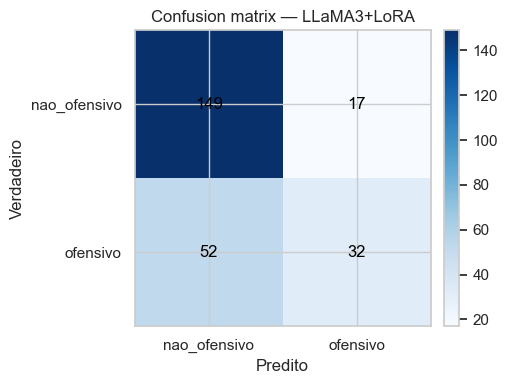

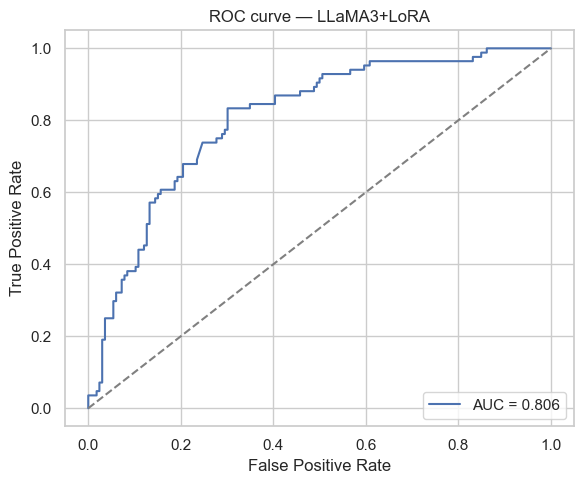

ROC AUC = 0.8056

Finished LLaMA3+LoRA (modelo/tokenizer salvos e objetos em memória).

=== Treinamento / avaliação LLaMA3+LoRA (offcombr-3) ===


Loading checkpoint shards: 100%|██████████| 4/4 [00:38<00:00,  9.63s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Starting LLaMA3+LoRA training for offcombr-3.


Epoch,Training Loss,Validation Loss
1,4.460400,0.376490



Classification report (LLaMA3 + LoRA):
              precision    recall  f1-score   support

nao_ofensivo     0.8717    0.9760    0.9209       167
    ofensivo     0.8000    0.4000    0.5333        40

    accuracy                         0.8647       207
   macro avg     0.8358    0.6880    0.7271       207
weighted avg     0.8578    0.8647    0.8460       207

Accuracy = 0.8647 | Precision_macro = 0.8358 | Recall_macro = 0.6880 | F1_macro = 0.7271


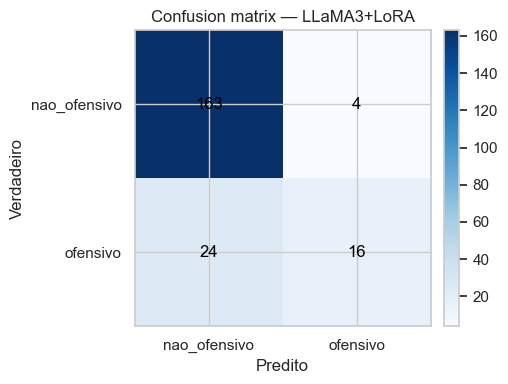

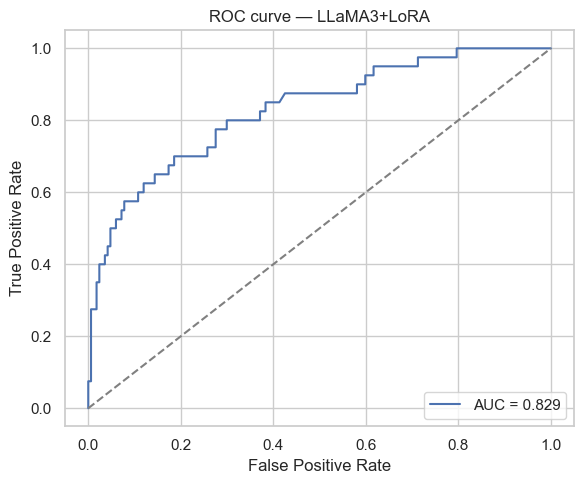

ROC AUC = 0.8287

Finished LLaMA3+LoRA (modelo/tokenizer salvos e objetos em memória).


In [16]:
# =========================
# 6. LLaMA3 + LoRA (treino + salvamento + registro em memória)
# =========================
import gc
from torch.nn.functional import softmax
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)

# ---- dicionários globais para reutilização em 6.1/6.2/7/7.1 ----
if "llama_tok"   not in globals(): llama_tok   = {}
if "llama_model" not in globals(): llama_model = {}
if "llama_metrics" not in globals(): llama_metrics = {}
if "llama_preds"   not in globals(): llama_preds   = {}
if "llama_scores"  not in globals(): llama_scores  = {}
if "llama_ytrue"   not in globals(): llama_ytrue   = {}
if "llama_Xtest"   not in globals(): llama_Xtest   = {}
if "comparacao_datasets" not in globals(): comparacao_datasets = {}

def treinar_llama_lora(
    cfg,
    X_train, y_train,
    X_eval,  y_eval,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    output_dir_base="./results_llama",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    max_len=192,
    use_4bit=True,
    seed=SEED
):
    """
    Fine-tune LLaMA3 para classificação (2 classes) com LoRA (k-bit + LoRA).
    - Mostra classification report, confusion matrix e ROC inline.
    - Salva tokenizer + adapters LoRA.
    - Retorna e registra em memória: tokenizer, model (com LoRA), métricas e predições.
    """
    if 'HAS_PEFT' in globals() and not HAS_PEFT:
        raise RuntimeError("PEFT/bitsandbytes não disponível. Instale 'peft' e 'bitsandbytes' para rodar LLaMA+LoRA.")

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=True, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    # HF Datasets
    ds_train = Dataset.from_dict({"text": list(X_train), "label": list(map(int, y_train))})
    ds_eval  = Dataset.from_dict({"text": list(X_eval),  "label": list(map(int, y_eval))})

    def tokenize_fn(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_len)

    ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
    ds_eval  = ds_eval.map(tokenize_fn, batched=True, remove_columns=["text"])
    ds_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    ds_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    # Bits & Bytes (k-bit)
    bnb_config = None
    if use_4bit:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )

    # antes de carregar o modelo do próximo cfg:
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Modelo base + head de classificação
    try:
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
        num_labels=2,
        quantization_config=bnb_config,   # 4-bit NF4
        device_map={"": 0},               # <-- força 100% no GPU:0 (evita CPU/disk)
        torch_dtype=torch.float16,        # <-- garante dtype compacto
        attn_implementation="sdpa",       # <-- usa SDPA (mais leve que eager)
        token=True                        # Busca automaticamente o token salvo
        )
    except Exception as e:
        print("[warn] 4-bit com device_map={'':0} falhou:", e)
        raise

    model = prepare_model_for_kbit_training(model)
    try:
        model.gradient_checkpointing_enable()
    except Exception:
        pass

    # LoRA
    lora_config = LoraConfig(
        r=16, lora_alpha=32,
        target_modules=["q_proj", "v_proj", "o_proj", "k_proj"],
        lora_dropout=0.05, bias="none", task_type="SEQ_CLS",
    )
    model = get_peft_model(model, lora_config)

    try:
        model.resize_token_embeddings(len(tokenizer))
    except Exception:
        pass

    outdir = os.path.join(output_dir_base, cfg, "llama_lora")
    os.makedirs(outdir, exist_ok=True)

    args = TrainingArguments(
        output_dir=outdir,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        eval_strategy="epoch",
        save_strategy="epoch",        # <-- salvar ao final de cada época
        logging_strategy="steps",
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        bf16=False,
        seed=seed,
        save_total_limit=1,
        dataloader_num_workers=2,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        tokenizer=tokenizer,
    )

    print(f"Starting LLaMA3+LoRA training for {cfg}.")
    trainer.train()

    # Garantia extra de salvamento (tokenizer + adapters)
    try:
        trainer.save_model(outdir)            # salva adapters LoRA
        tokenizer.save_pretrained(outdir)
    except Exception as e:
        print("[warn] Falha ao salvar modelo/tokenizer:", e)

    # Predições
    pred_out = trainer.predict(ds_eval)
    logits = pred_out.predictions if not isinstance(pred_out.predictions, tuple) else pred_out.predictions[0]

    y_pred = np.argmax(logits, axis=-1)
    y_score = softmax(torch.tensor(logits), dim=-1)[:, 1].cpu().numpy()
    y_true_arr = np.asarray(list(map(int, y_eval)))

    # Relatório
    print("\nClassification report (LLaMA3 + LoRA):")
    print(classification_report(y_true_arr, y_pred, digits=4, target_names=["nao_ofensivo","ofensivo"]))

    # Métricas macro (compatíveis com RF/BERT)
    acc = float(accuracy_score(y_true_arr, y_pred))
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_true_arr, y_pred, average="macro", zero_division=0)
    print(f"Accuracy = {acc:.4f} | Precision_macro = {prec_m:.4f} | Recall_macro = {rec_m:.4f} | F1_macro = {f1_m:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true_arr, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap="Blues", interpolation="nearest")
    ax.set_xlabel("Predito"); ax.set_ylabel("Verdadeiro")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["nao_ofensivo","ofensivo"]); ax.set_yticklabels(["nao_ofensivo","ofensivo"])
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha="center", va="center", color="black")
    plt.title("Confusion matrix — LLaMA3+LoRA")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # ROC AUC (se ambas classes presentes)
    if len(np.unique(y_true_arr)) > 1:
        try:
            auc = float(roc_auc_score(y_true_arr, y_score))
            fpr, tpr, _ = roc_curve(y_true_arr, y_score)
            fig, ax = plt.subplots(figsize=(6,5))
            ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
            ax.plot([0,1],[0,1], linestyle="--", color="grey")
            ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
            ax.set_title("ROC curve — LLaMA3+LoRA")
            ax.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
            print(f"ROC AUC = {auc:.4f}")
        except Exception as e:
            print("Falha ao calcular ROC AUC:", e)
    else:
        print("ROC AUC não calculado: somente uma classe presente.")

    # --- registra em memória (p/ 6.1, 6.2, 7, 7.1) ---
    llama_tok[cfg]   = tokenizer
    llama_model[cfg] = model
    llama_metrics[cfg] = {"accuracy":acc, "precision_macro":float(prec_m),
                          "recall_macro":float(rec_m), "f1_macro":float(f1_m)}
    llama_preds[cfg]  = y_pred
    llama_scores[cfg] = y_score
    llama_ytrue[cfg]  = y_true_arr
    llama_Xtest[cfg]  = list(X_eval)

    # Atualiza sua estrutura comparacao_datasets (mantendo compatibilidade)
    prev_results = comparacao_datasets.get(cfg + "_raw_results", [])
    res_llama = {
        "Modelo": "LLaMA3 + LoRA",
        "cfg": cfg,
        "Accuracy": acc,
        "Precision": float(prec_m),
        "Recall": float(rec_m),
        "F1-score": float(f1_m),
        "y_score": y_score,
        "y_pred": y_pred
    }
    comparacao_datasets[cfg + "_raw_results"] = prev_results + [res_llama]
    comparacao_datasets[cfg + "_ytest"] = y_true_arr
    comparacao_datasets[cfg + "_Xtest"] = list(X_eval)
    comparacao_datasets[cfg] = pd.DataFrame([{
        "Modelo":"LLaMA3 + LoRA", "cfg": cfg, "Accuracy": acc,
        "Precision": float(prec_m), "Recall": float(rec_m), "F1-score": float(f1_m)
    }])

    print("\nFinished LLaMA3+LoRA (modelo/tokenizer salvos e objetos em memória).")
    return {"tokenizer": tokenizer, "model": model, "metrics": llama_metrics[cfg],
            "y_pred": y_pred, "y_score": y_score, "y_true": y_true_arr, "outdir": outdir}

# --------------------------
# Execução por CONFIG (inline results)
# --------------------------
for cfg in CONFIGS:
    print(f"\n=== Treinamento / avaliação LLaMA3+LoRA ({cfg}) ===")
    X_train = splits[cfg]["train_text"]
    y_train = splits[cfg]["train_y"]
    X_test  = splits[cfg]["test_text"]
    y_test  = splits[cfg]["test_y"]
    _ = treinar_llama_lora(
        cfg,
        X_train, y_train,
        X_test,  y_test,
        model_name="meta-llama/Meta-Llama-3-8B-Instruct",
        output_dir_base="./results_llama",
        num_train_epochs=1,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=8,
        learning_rate=2e-4,
        max_len=256,
        use_4bit=True
    )

## 6.1. Avaliador LLM (Llama3 Instruct) + 6.2 SHAP no LLM (masker de texto) ##


=== SHAP: LLaMA3+LoRA (offcombr-2) ===
Usando 250 textos de teste de splits[offcombr-2]['test_text'].
Rodando SHAP em 100 textos…


100%|██████████| 342/342 [00:17<00:00, 14.74it/s]
348it [00:17, 15.00it/s]                         
354it [00:18, 14.69it/s]
360it [00:18, 15.00it/s]
366it [00:19, 14.07it/s]
372it [00:19, 14.38it/s]
378it [00:19, 14.57it/s]
384it [00:20, 14.18it/s]
390it [00:20, 14.70it/s]
396it [00:21, 15.11it/s]
402it [00:21, 13.63it/s]
408it [00:22, 14.26it/s]
414it [00:22, 14.69it/s]
420it [00:22, 13.58it/s]
426it [00:23, 14.25it/s]
432it [00:23, 14.60it/s]
438it [00:24, 13.82it/s]
444it [00:24, 14.30it/s]
450it [00:25, 14.46it/s]
456it [00:25, 13.32it/s]
462it [00:26, 13.17it/s]
468it [00:26, 10.74it/s]
474it [00:27,  9.52it/s]
476it [00:28,  6.49it/s]
 99%|█████████▉| 494/498 [00:43<00:00, 11.75it/s]
500it [00:44, 11.56it/s]                         
504it [00:44, 10.99it/s]
 99%|█████████▉| 494/498 [00:34<00:00, 12.44it/s]
500it [00:34, 12.58it/s]                         
504it [00:35, 11.05it/s]
 99%|█████████▉| 494/498 [00:33<00:00, 12.16it/s]
500it [00:33, 12.64it/s]                         


SHAP LLaMA3+LoRA falhou para offcombr-2: zero-size array to reduction operation maximum which has no identity

=== SHAP: LLaMA3+LoRA (offcombr-3) ===
Usando 207 textos de teste de splits[offcombr-3]['test_text'].
Rodando SHAP em 100 textos…


 99%|█████████▉| 494/498 [00:33<00:00, 12.69it/s]
500it [00:33, 13.22it/s]                         
504it [00:34, 11.42it/s]
100%|██████████| 182/182 [00:08<00:00, 13.24it/s]
188it [00:08, 13.20it/s]                         
192it [00:09, 11.64it/s]
 99%|█████████▉| 494/498 [00:32<00:00, 12.59it/s]
500it [00:33, 12.77it/s]                         
504it [00:33, 11.26it/s]
 98%|█████████▊| 236/240 [00:12<00:00, 12.96it/s]
242it [00:13, 12.74it/s]                         
248it [00:13, 12.83it/s]
254it [00:14, 12.14it/s]
260it [00:14, 11.36it/s]
266it [00:15, 10.64it/s]
268it [00:16,  8.29it/s]
272it [00:16,  8.11it/s]
 99%|█████████▉| 494/498 [00:32<00:00, 11.97it/s]
500it [00:33, 11.77it/s]                         
504it [00:33, 10.79it/s]
 97%|█████████▋| 152/156 [00:06<00:00, 14.37it/s]
158it [00:06, 13.97it/s]                         
164it [00:07, 13.23it/s]
168it [00:07, 11.89it/s]
 99%|█████████▉| 494/498 [00:33<00:00, 12.28it/s]
500it [00:34, 12.37it/s]                         


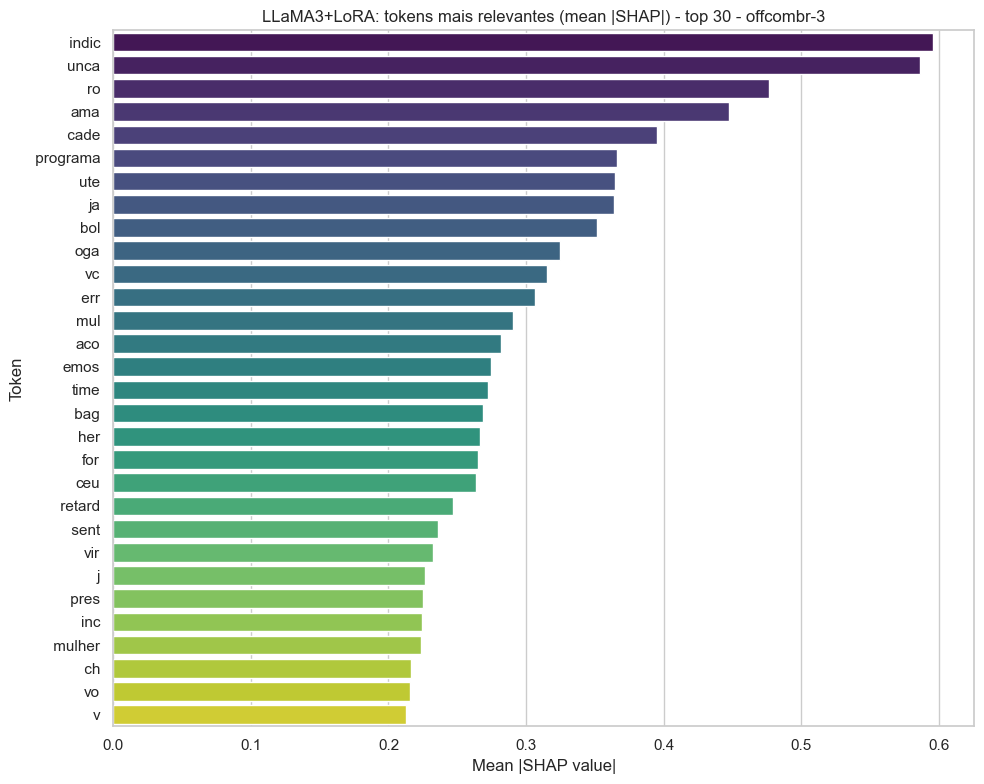

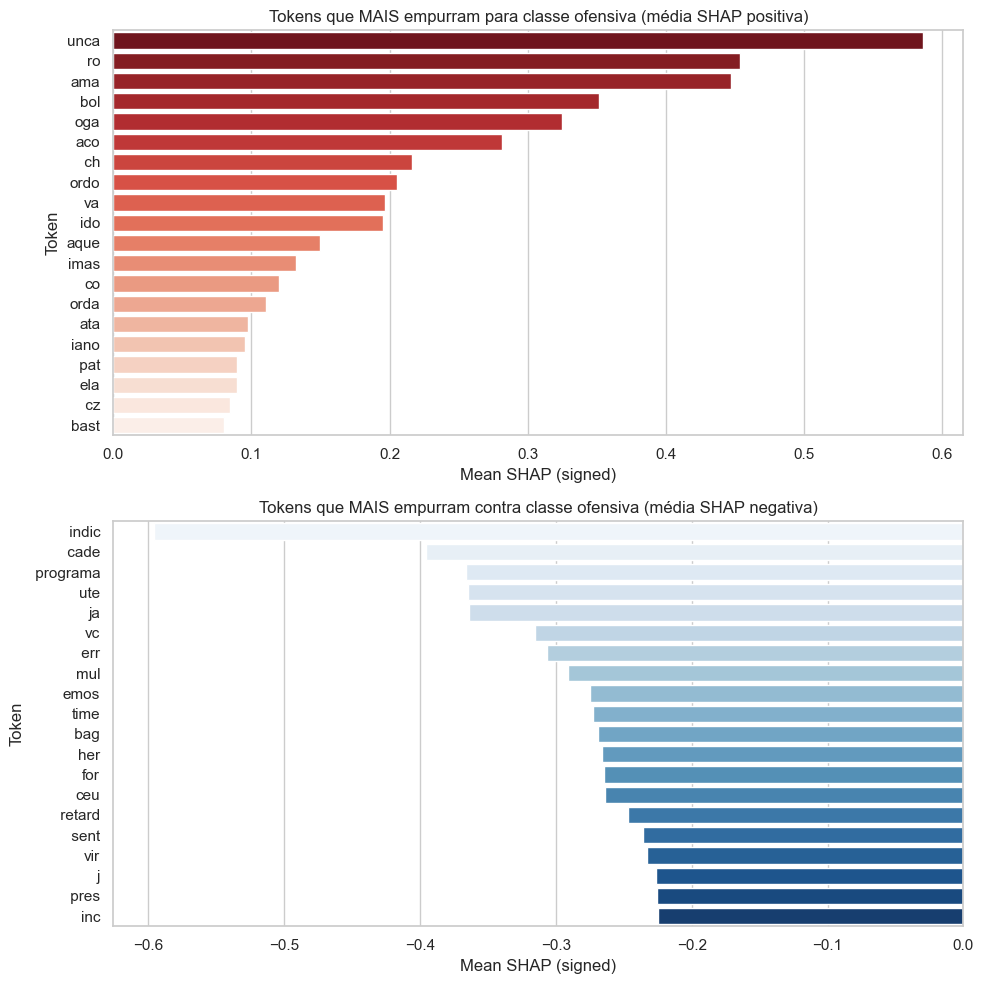

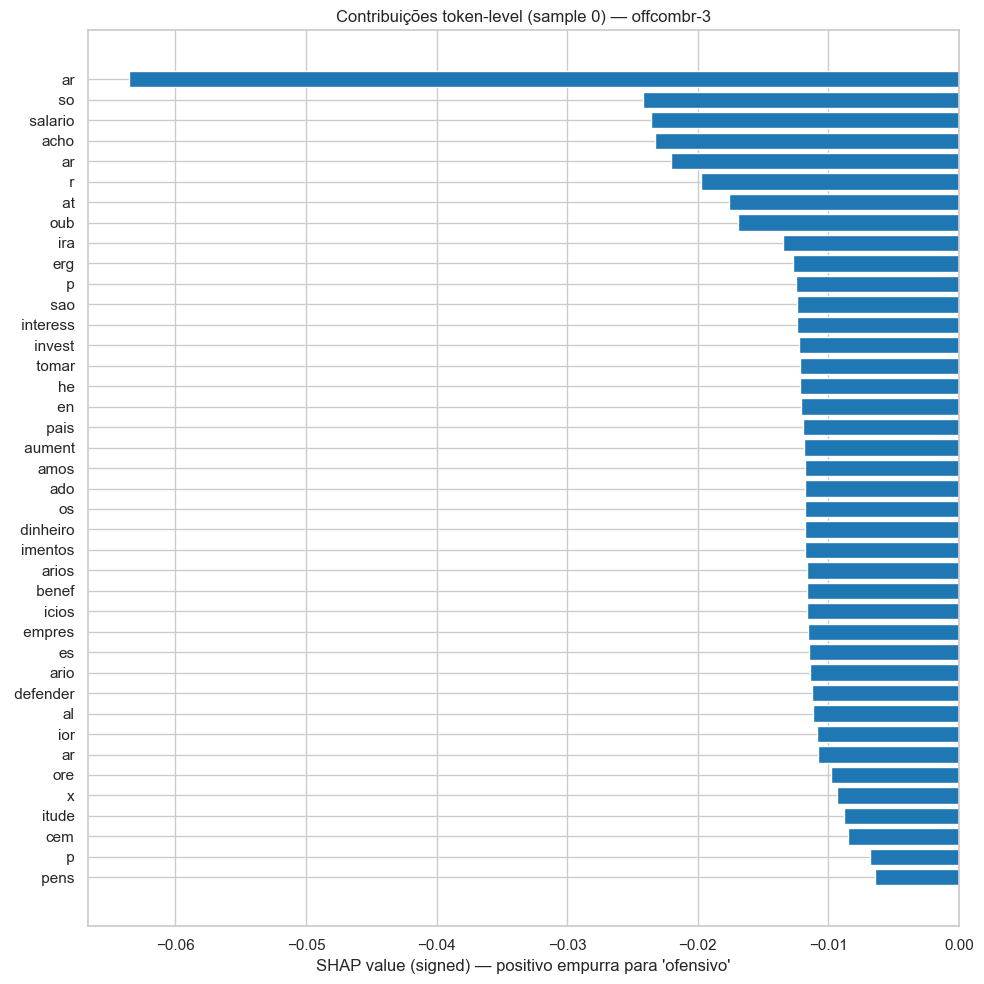

Sample 0 text (preprocessed): acho engracado governantes pensam cortar regalias beneficios desnecessarios favorecem sera ne claro ate enxergar sao estao defender proprios interesses empresario casso tambem comecamos tomar atitude mudar roubalheira pais tendencia so piorar povo dinheiro investimentos aumentos salario


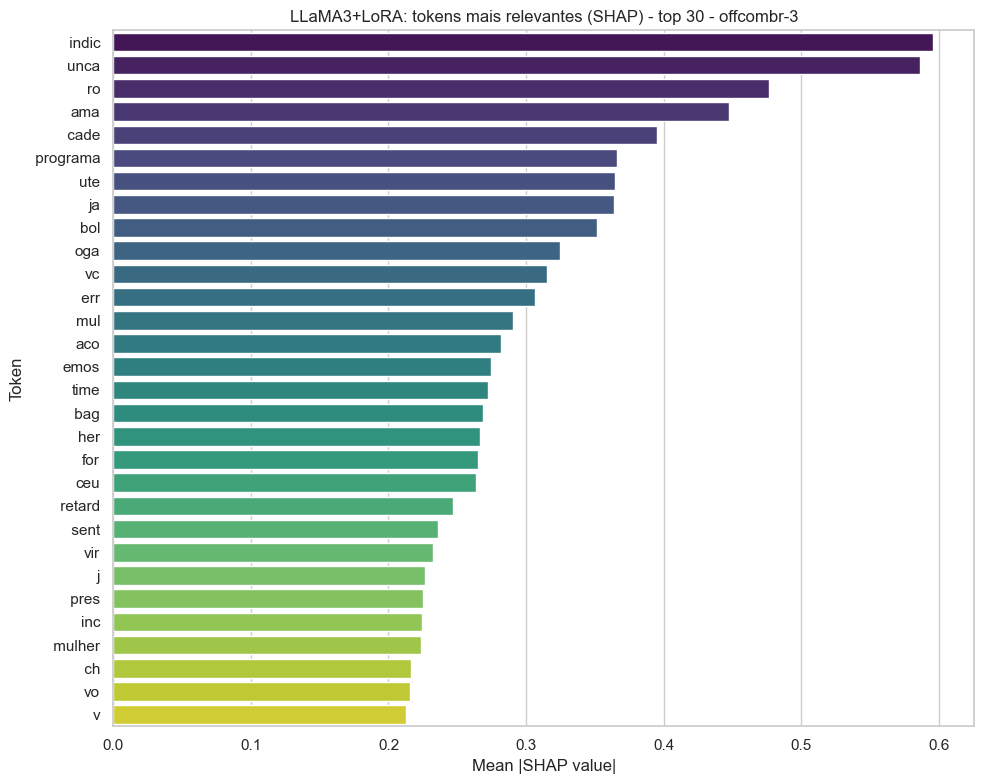

In [17]:
# ============================================================
# 6.1 Avaliador LLaMA3+LoRA + 6.2 SHAP para LLaMA3+LoRA (masker de texto)
# ============================================================
sns.set(style="whitegrid", font_scale=1.0)
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("./outputs/shap", exist_ok=True)

def make_predict_proba_fn_llama(tokenizer, model, device):
    """Retorna função predict_proba(texts)-> array (N,) com prob. da classe ofensiva (índice 1)."""
    model.to(device)
    model.eval()
    def predict_proba(texts, batch_size=16, max_length=256):
        probs = []
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(list(batch), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
                enc = {k: v.to(device) for k, v in enc.items()}
                logits = model(**enc).logits
                p = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()  # classe positiva = ofensivo
                probs.append(p)
        if len(probs) == 0:
            return np.array([])
        return np.concatenate(probs, axis=0)
    return predict_proba

for cfg in CONFIGS:
    try:
        print(f"\n=== SHAP: LLaMA3+LoRA ({cfg}) ===")

        # Verifica existência do modelo/tokenizer treinados na Seção 6
        if cfg not in llama_tok or cfg not in llama_model:
            print(f"[LLAMA:{cfg}] Modelo/tokenizer não encontrados. Execute a Seção 6 antes.")
            continue

        test_texts = list(splits[cfg]["test_text"])
        if len(test_texts) == 0:
            print(f"Não há textos de teste em splits[{cfg}]['test_text']. Pulando.")
            continue
        print(f"Usando {len(test_texts)} textos de teste de splits[{cfg}]['test_text'].")

        tokenizer_llama = llama_tok[cfg]
        model_llama = llama_model[cfg]

        # --- 6.1 Avaliador — métricas de sanity inline ---
        # Calcula preds rapidamente para relatório
        with torch.no_grad():
            # usa a mesma função de prob. que alimenta o SHAP
            predict_proba = make_predict_proba_fn_llama(tokenizer_llama, model_llama, device)
            p_off = predict_proba(test_texts, batch_size=16, max_length=256)
            y_pred = (p_off >= 0.5).astype(int)
        y_true = np.asarray(splits[cfg]["test_y"])

        # --- 6.2 SHAP textual ---
        masker = shap.maskers.Text(tokenizer_llama)
        explainer = shap.Explainer(predict_proba, masker)

        subset = test_texts[:100] if len(test_texts) > 100 else test_texts
        print(f"Rodando SHAP em {len(subset)} textos…")
        shap_explanations = explainer(subset)

        # ---- Agregação: mean |SHAP| por token e média assinada (direção) ----
        tokens_abs = []
        tokens_signed = []
        for ex in shap_explanations:
            toks = ex.data
            vals = ex.values
            # Normaliza shape: (n_tokens,) esperado; se vier (1, n_tokens), pega o primeiro
            if hasattr(vals, "ndim") and vals.ndim == 2:
                vals = vals[0]
            # tokens especiais do tokenizer (p.ex. <s>, </s>, <pad>) não entram no ranking
            for t, v in zip(toks, vals):
                if t in tokenizer_llama.all_special_tokens:
                    continue
                v = float(v)
                tokens_abs.append({"token": t, "abs_shap": abs(v)})
                tokens_signed.append({"token": t, "signed_shap": v})

        df_abs = pd.DataFrame(tokens_abs)
        df_signed = pd.DataFrame(tokens_signed)
        if df_abs.empty or df_signed.empty:
            raise RuntimeError("Nenhum token válido encontrado para agregação SHAP (LLaMA).")

        df_token_summary = df_abs.groupby("token")["abs_shap"].mean().reset_index()
        df_token_summary = df_token_summary.sort_values("abs_shap", ascending=False)

        df_token_signed = df_signed.groupby("token")["signed_shap"].mean().reset_index()
        df_token_signed = df_token_signed.sort_values("signed_shap", ascending=False)

        # ---- Plot 1: Importância global (mean |SHAP|) ----
        plt.figure(figsize=(10, 8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"LLaMA3+LoRA: tokens mais relevantes (mean |SHAP|) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

        # ---- Plot 2: Importância assinada (direção p/ classe ofensiva) ----
        top_pos = df_token_signed.sort_values("signed_shap", ascending=False).head(20)
        top_neg = df_token_signed.sort_values("signed_shap", ascending=True).head(20)

        plt.figure(figsize=(10, 10))
        plt.subplot(2,1,1)
        sns.barplot(data=top_pos, x="signed_shap", y="token", palette="Reds_r")
        plt.title("Tokens que MAIS empurram para classe ofensiva (média SHAP positiva)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.subplot(2,1,2)
        sns.barplot(data=top_neg, x="signed_shap", y="token", palette="Blues")
        plt.title("Tokens que MAIS empurram contra classe ofensiva (média SHAP negativa)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.tight_layout()
        plt.show()

        # ---- Plot 3: Explicação local (amostra 0 do subset) ----
        if len(shap_explanations) > 0:
            ex0 = shap_explanations[0]
            toks0 = ex0.data
            vals0 = ex0.values
            if hasattr(vals0, "ndim") and vals0.ndim == 2:
                vals0 = vals0[0]

            token_vals = [(t, float(v)) for t, v in zip(toks0, vals0) if t not in tokenizer_llama.all_special_tokens]
            if token_vals:
                names = [t for t, _ in token_vals]
                vals = np.array([v for _, v in token_vals], dtype=float)
                order = np.argsort(np.abs(vals))[::-1][:40]
                vals_plot = vals[order]
                names_plot = np.array(names)[order]

                plt.figure(figsize=(10, max(3, len(names_plot)*0.25)))
                colors = ["tab:red" if v > 0 else "tab:blue" for v in vals_plot]
                plt.barh(range(len(vals_plot)), vals_plot, color=colors)
                plt.yticks(range(len(vals_plot)), names_plot)
                plt.gca().invert_yaxis()
                plt.xlabel("SHAP value (signed) — positivo empurra para 'ofensivo'")
                plt.title(f"Contribuições token-level (sample 0) — {cfg}")
                plt.tight_layout()
                plt.show()

                print("Sample 0 text (preprocessed):", subset[0])

        # um segundo gráfico global repetindo top tokens
        plt.figure(figsize=(10, 8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"LLaMA3+LoRA: tokens mais relevantes (SHAP) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP LLaMA3+LoRA falhou para {cfg}:", e)

## 7. Comparação Final (Random Forest vs. BERTimbau vs. LLM Llama3) + 7.1 Interpretação de Erros (Random Forest × BERTimbau x LLM Llama3) ##
Esta seção mostra amostras mal classificadas com suas explicações SHAP.
- RF e LR: gráfico de barras com contribuições locais (TF‑IDF).
- BERTimbau: explicação textual com `shap.maskers.Text`.
- LLM Llama3: explicação textual com `shap.maskers.Text`.



=== Comparação de Modelos - OFFCOMBR-2 ===


,Modelo,cfg,accuracy,precision_macro,recall_macro,f1_macro,precision_pos,recall_pos,f1_pos
0,RandomForest,offcombr-2,0.748,0.717445,0.716150,0.716783,0.626506,0.619048,0.622754
1,LogReg (char+word TF-IDF),offcombr-2,0.804,0.790433,0.755379,0.767548,0.761194,0.607143,0.675497
2,BERTimbau,offcombr-2,0.796,0.771831,0.784639,0.776985,0.677419,0.750000,0.711864
3,LLaMA3+LoRA,offcombr-2,0.724,0.697177,0.639271,0.646596,0.653061,0.380952,0.481203


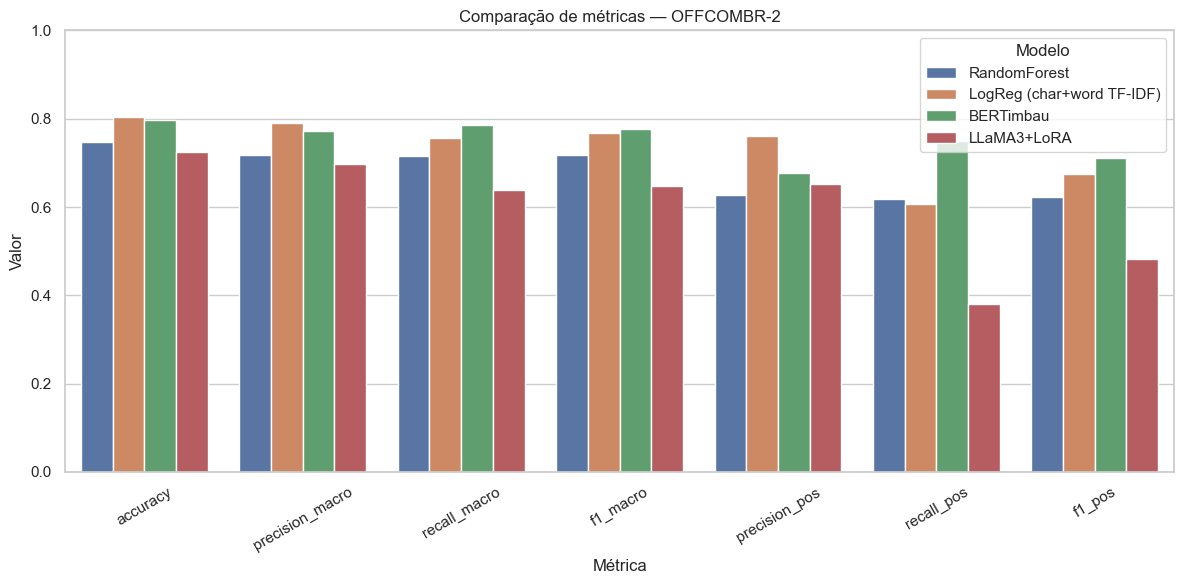

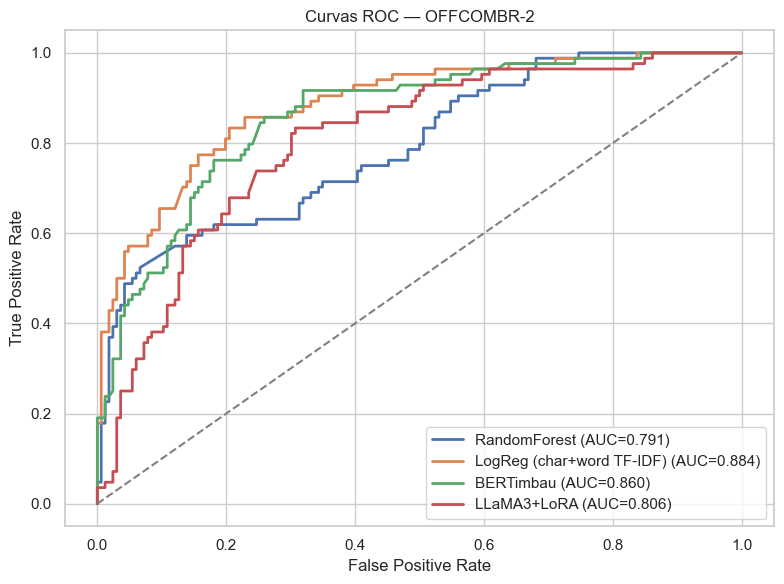

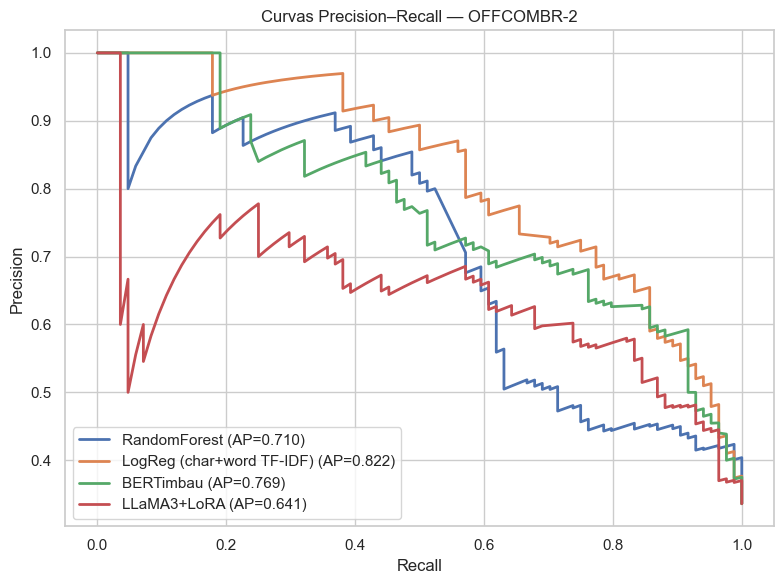

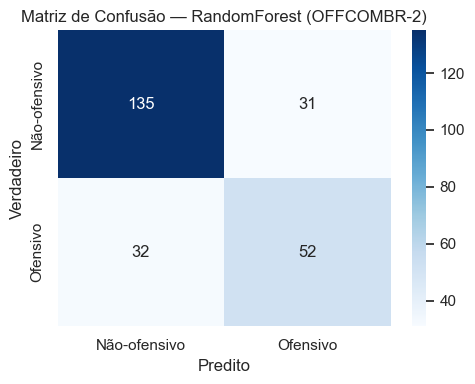

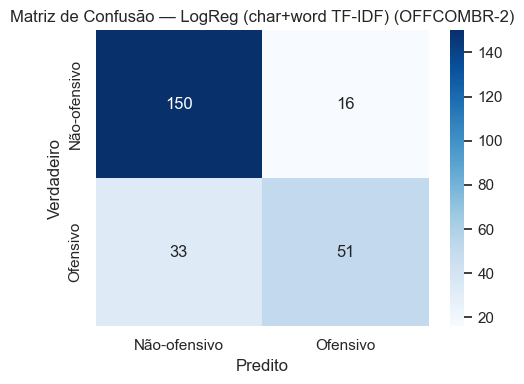

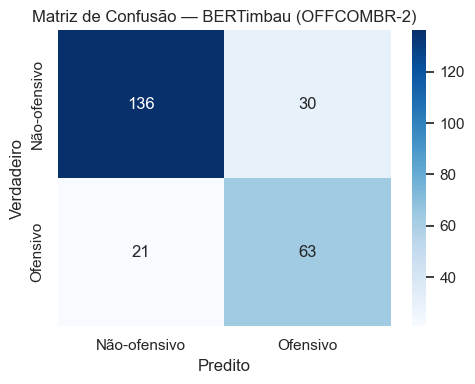

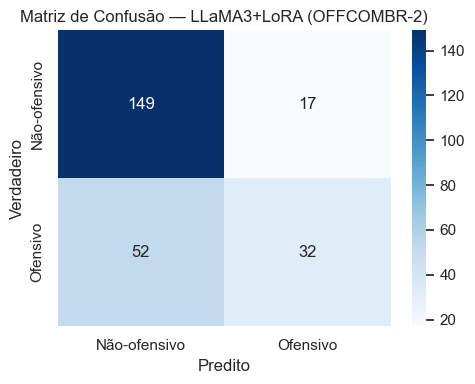

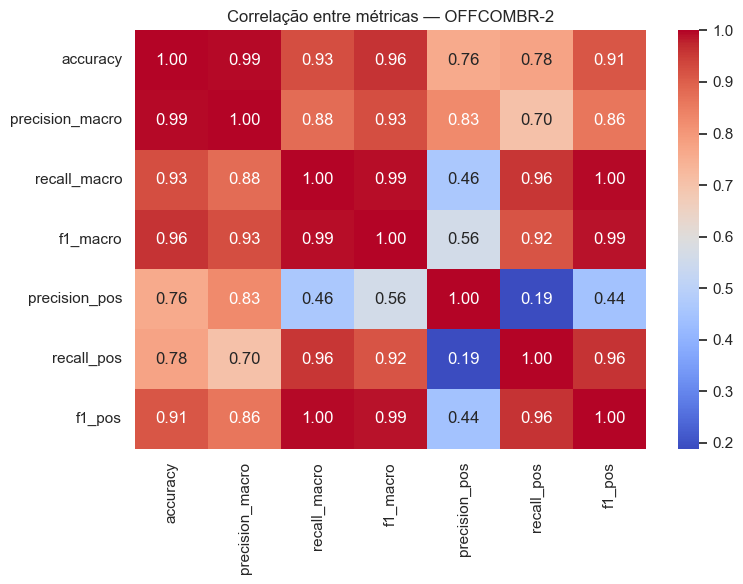


=== Comparação de Modelos - OFFCOMBR-3 ===


,Modelo,cfg,accuracy,precision_macro,recall_macro,f1_macro,precision_pos,recall_pos,f1_pos
0,RandomForest,offcombr-3,0.835749,0.854585,0.584506,0.599385,0.875000,0.175,0.291667
1,LogReg (char+word TF-IDF),offcombr-3,0.869565,0.857223,0.691018,0.733158,0.842105,0.400,0.542373
2,BERTimbau,offcombr-3,0.874396,0.815819,0.751048,0.776495,0.733333,0.550,0.628571
3,LLaMA3+LoRA,offcombr-3,0.864734,0.835829,0.688024,0.727119,0.800000,0.400,0.533333


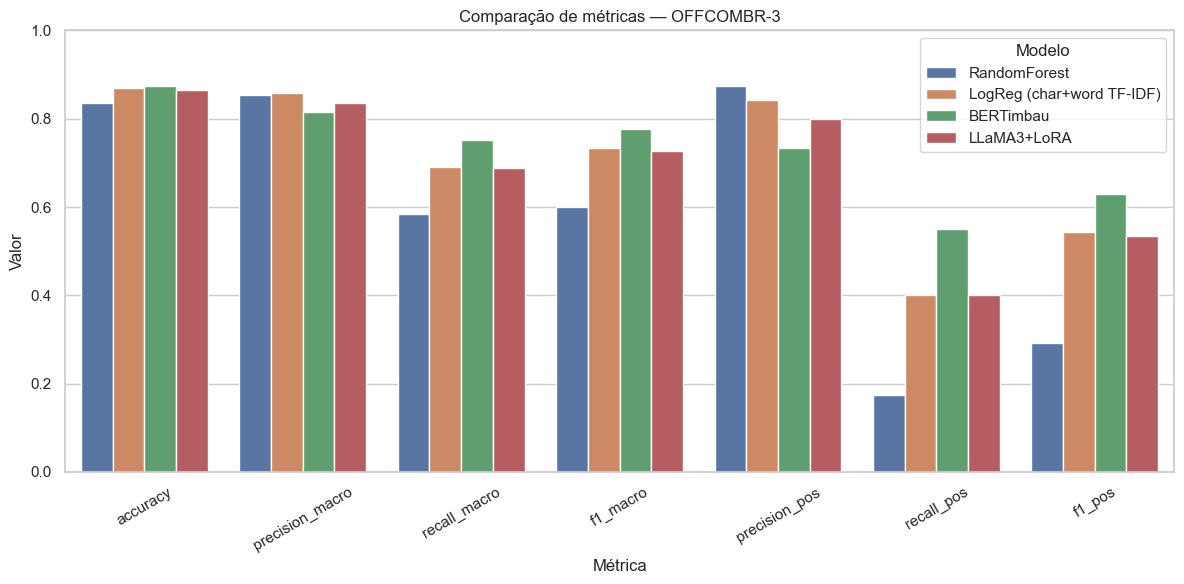

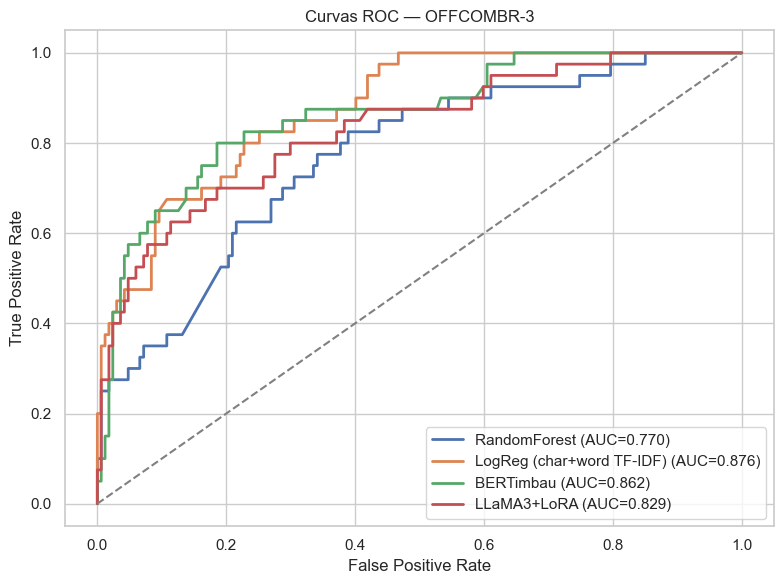

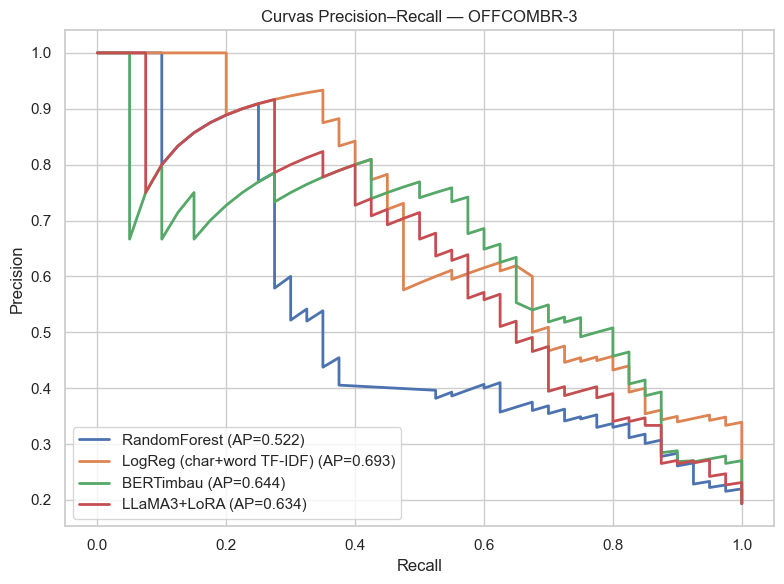

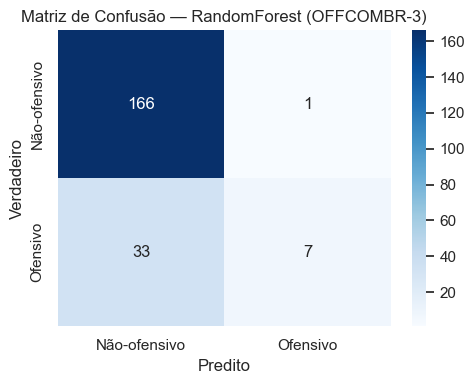

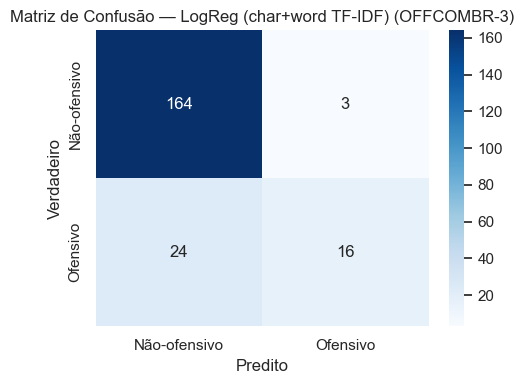

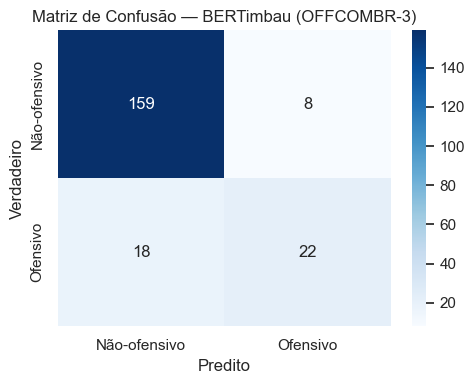

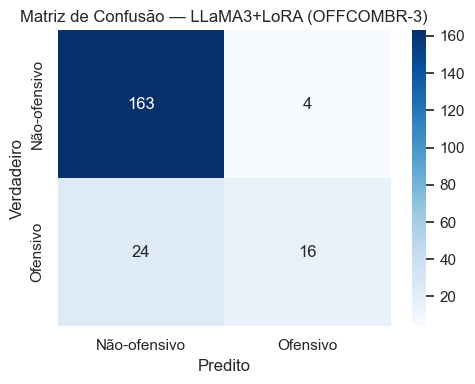

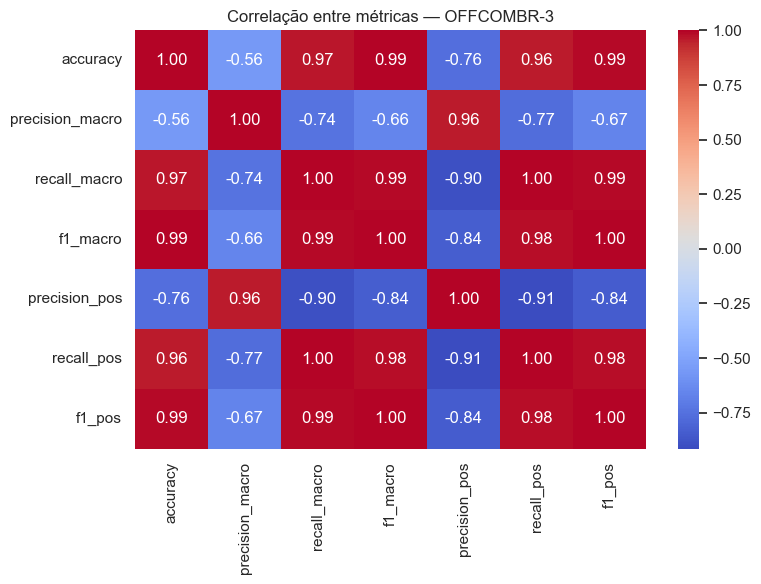


=== Tabela consolidada (por dataset) ===


cfg  accuracy  precision_macro  \
           Modelo                                                             
offcombr-2 RandomForest               offcombr-2  0.748000         0.717445   
           LogReg (char+word TF-IDF)  offcombr-2  0.804000         0.790433   
           BERTimbau                  offcombr-2  0.796000         0.771831   
           LLaMA3+LoRA                offcombr-2  0.724000         0.697177   
offcombr-3 RandomForest               offcombr-3  0.835749         0.854585   
           LogReg (char+word TF-IDF)  offcombr-3  0.869565         0.857223   
           BERTimbau                  offcombr-3  0.874396         0.815819   
           LLaMA3+LoRA                offcombr-3  0.864734         0.835829   

                                      recall_macro  f1_macro  precision_pos  \
           Modelo                                                             
offcombr-2 RandomForest                   0.716150  0.716783       0.626506   
           LogReg (char+word TF-IDF)      0.755379  0.767548       0.761194   
           BERTimbau                      0.784639  0.776985       0.677419   
           LLaMA3+LoRA                    0.639271  0.646596       0.653061   
offcombr-3 RandomForest                   0.584506  0.599385       0.875000   
           LogReg (char+word TF-IDF)      0.691018  0.733158       0.842105   
           BERTimbau                      0.751048  0.776495       0.733333   
           LLaMA3+LoRA                    0.688024  0.727119       0.800000   

                                      recall_pos    f1_pos  
           Modelo                                           
offcombr-2 RandomForest                 0.619048  0.622754  
           LogReg (char+word TF-IDF)    0.607143  0.675497  
           BERTimbau                    0.750000  0.711864  
           LLaMA3+LoRA                  0.380952  0.481203  
offcombr-3 RandomForest                 0.175000  0.291667  
           LogReg (char+word TF-IDF)    0.400000  0.542373  
           BERTimbau                    0.550000  0.628571  
           LLaMA3+LoRA                  0.400000  0.533333

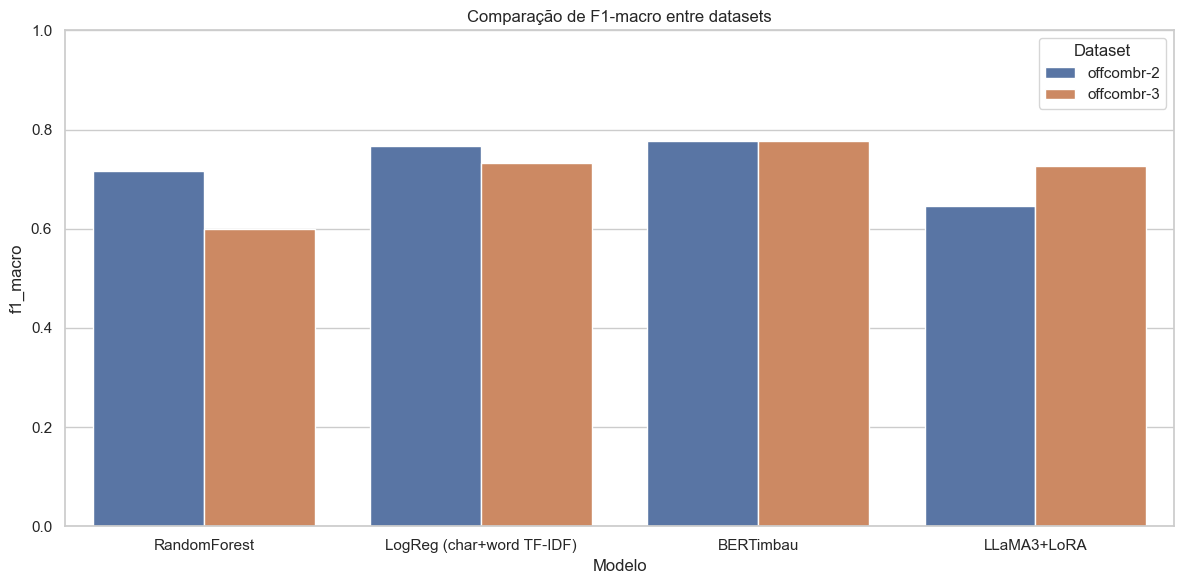

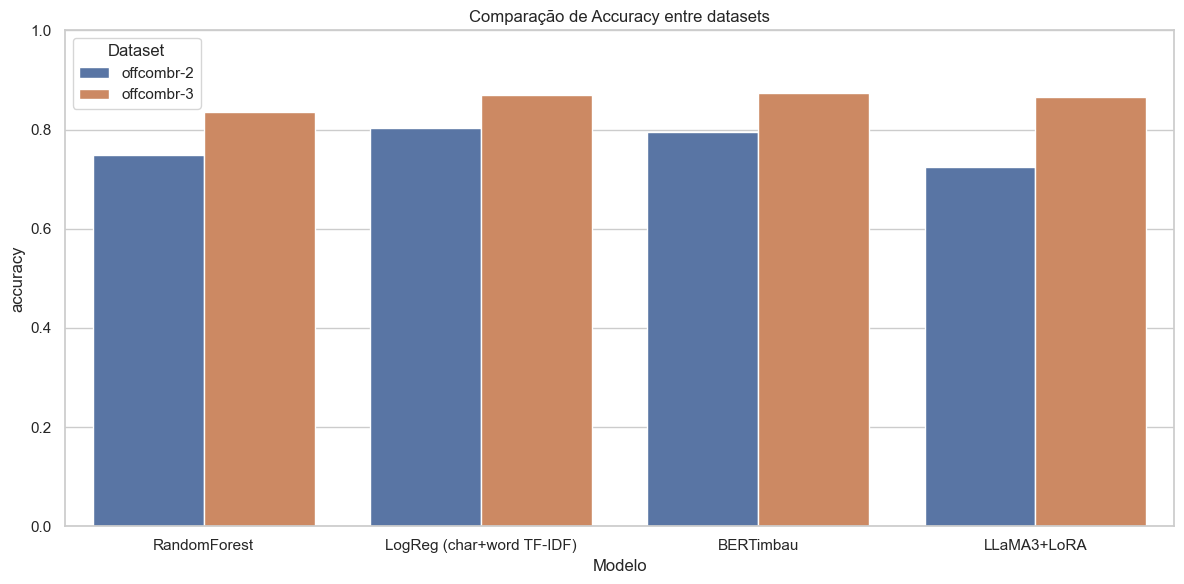


### Interpretação de erros — offcombr-2

------------------------------------------------------------------------------------------
[idx=1] TRUE=1 | Texto: flam aproveita juiz bandeirinhas profissional
  - RF: PRED=1 | score=0.580
  - BERT: PRED=1 | score=0.522
  - LLAMA: PRED=0 | score=0.002


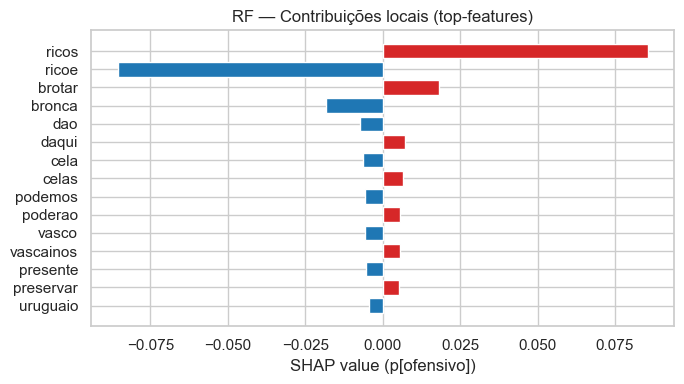

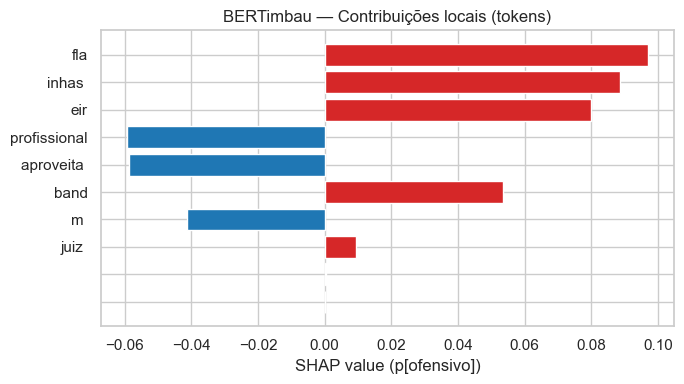

PartitionExplainer explainer: 2it [00:30, 30.18s/it]               


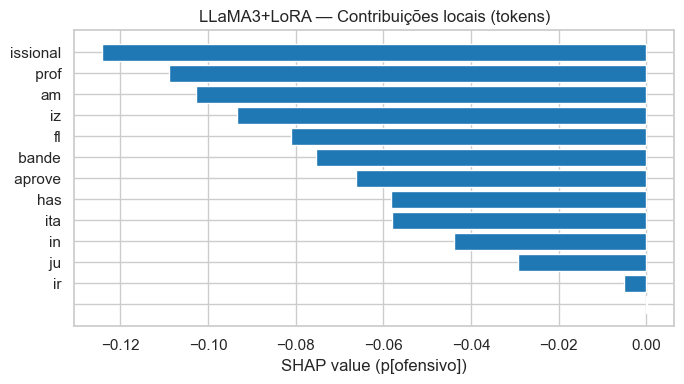


------------------------------------------------------------------------------------------
[idx=2] TRUE=0 | Texto: romariogtronaldogtzidanegtmessigtronaldinhogtcr
  - RF: PRED=1 | score=0.537
  - BERT: PRED=1 | score=0.818
  - LLAMA: PRED=1 | score=0.955


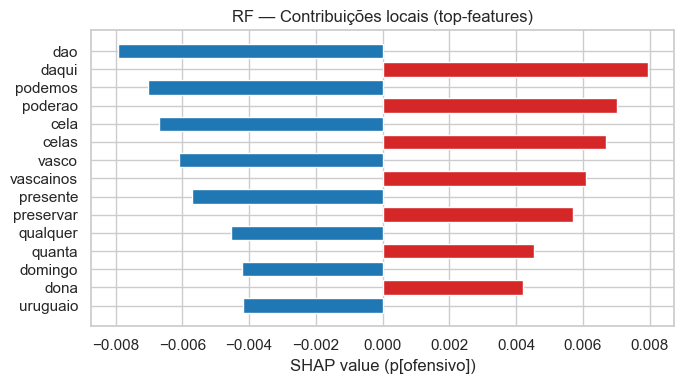

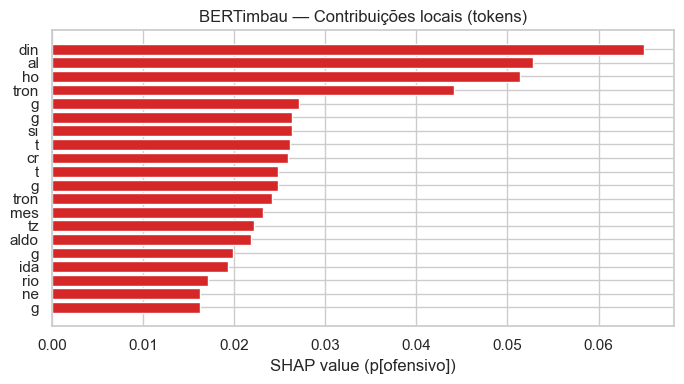

PartitionExplainer explainer: 2it [01:29, 89.68s/it]               


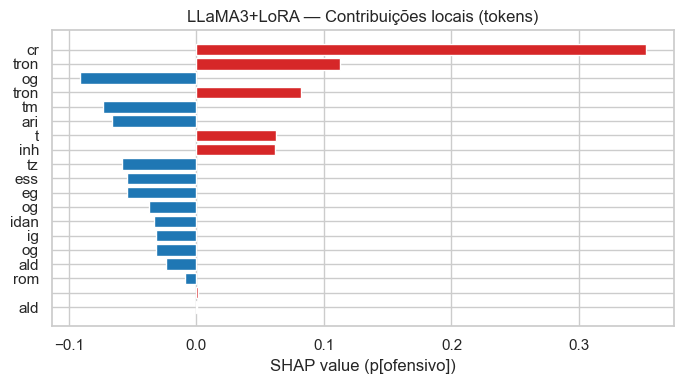


------------------------------------------------------------------------------------------
[idx=3] TRUE=0 | Texto: prefere usar damiao vizeu comentarios
  - RF: PRED=1 | score=0.553
  - BERT: PRED=0 | score=0.055
  - LLAMA: PRED=0 | score=0.037


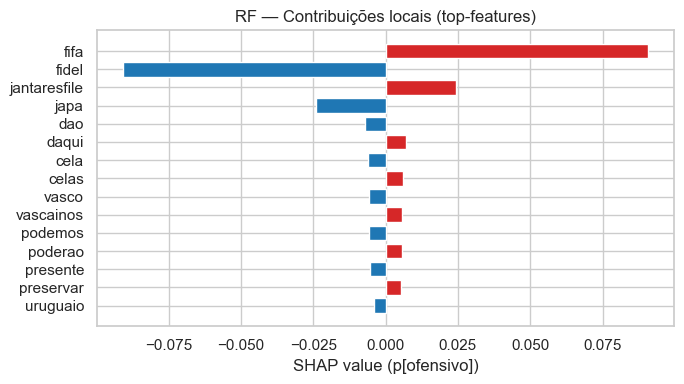

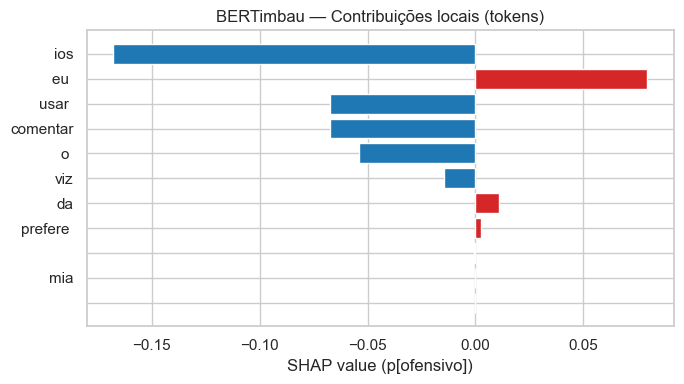

PartitionExplainer explainer: 2it [00:14, 14.61s/it]               


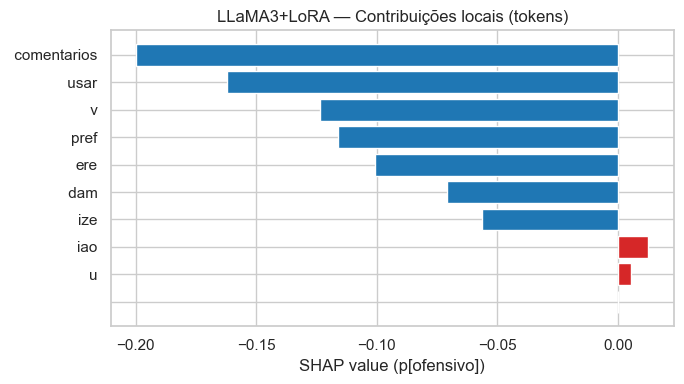


### Interpretação de erros — offcombr-3

------------------------------------------------------------------------------------------
[idx=1] TRUE=0 | Texto: bastou afundarem brasil
  - RF: PRED=0 | score=0.324
  - BERT: PRED=0 | score=0.018
  - LLAMA: PRED=1 | score=0.587


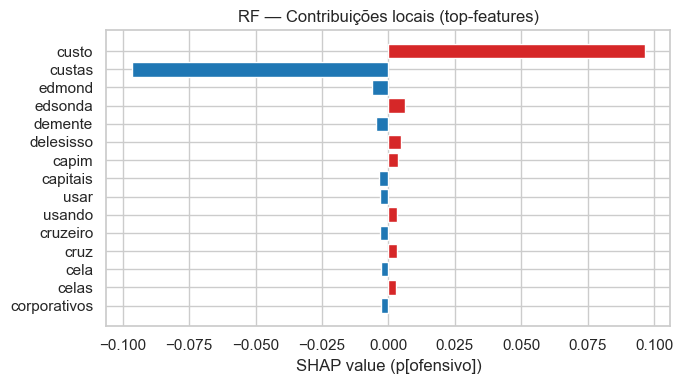

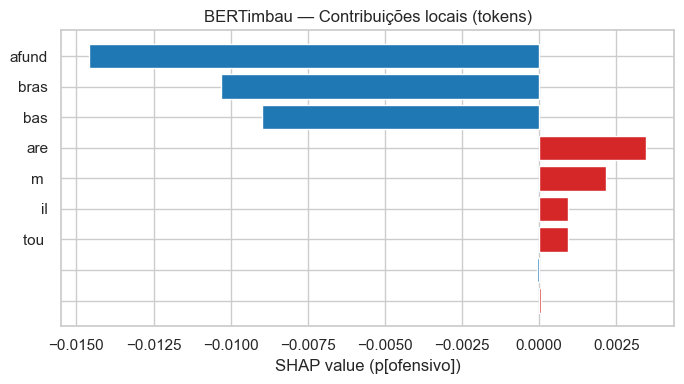

PartitionExplainer explainer: 2it [00:10, 10.91s/it]               


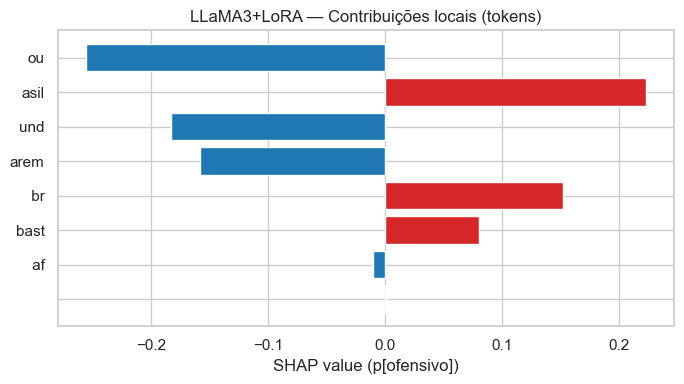


------------------------------------------------------------------------------------------
[idx=2] TRUE=0 | Texto: joga
  - RF: PRED=0 | score=0.204
  - BERT: PRED=0 | score=0.060
  - LLAMA: PRED=1 | score=0.740


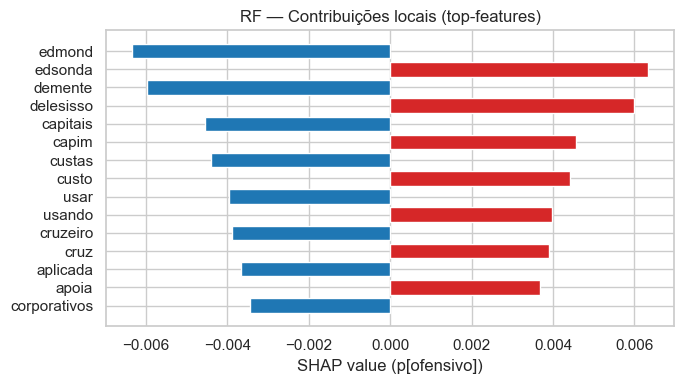

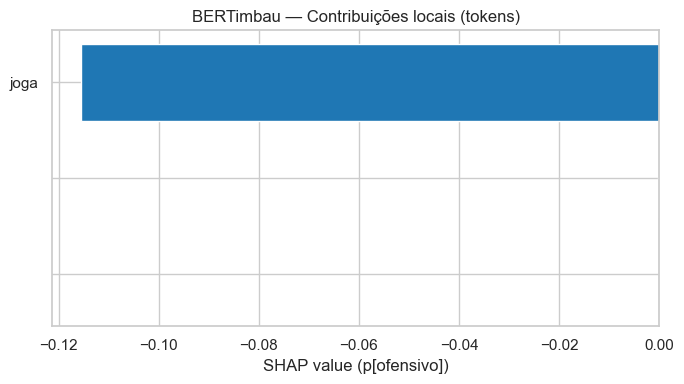

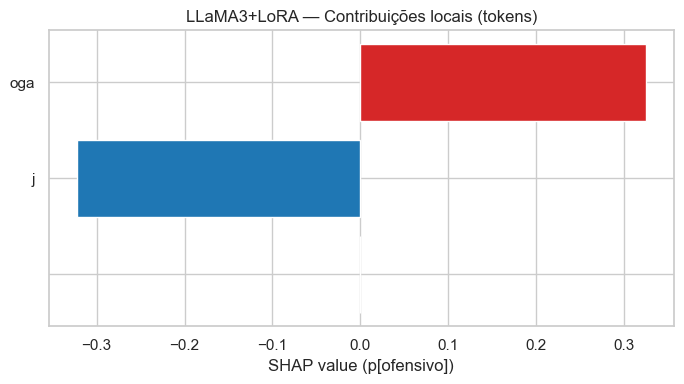


------------------------------------------------------------------------------------------
[idx=5] TRUE=1 | Texto: corrupta terrorista apresenta ameaca honesto povo uruguaio
  - RF: PRED=0 | score=0.203
  - BERT: PRED=0 | score=0.022
  - LLAMA: PRED=0 | score=0.022


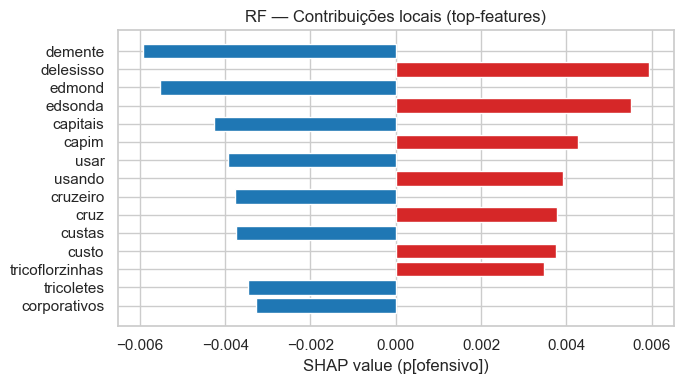

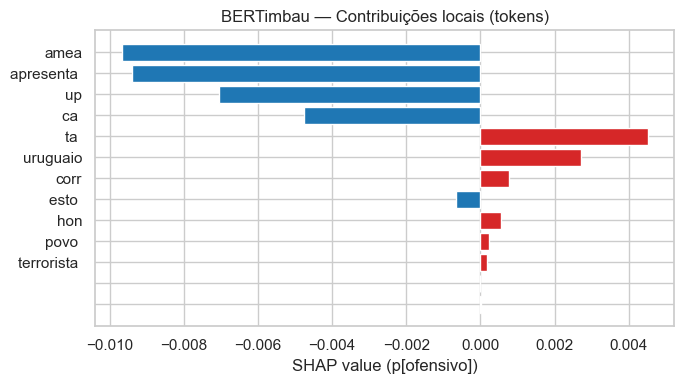

PartitionExplainer explainer: 2it [01:25, 85.77s/it]               


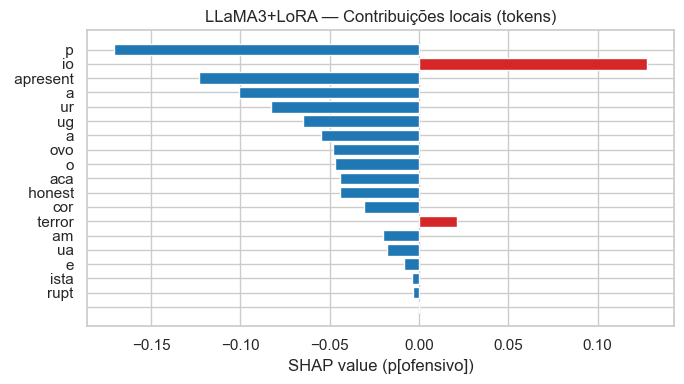

In [18]:
# =========================
# 7 + 7.1 — Avaliação consolidada (métricas, ROC/PR, confusão, correlação) + Interpretação de erros (RF × BERTimbau × LLaMA3+LoRA)
# =========================
import gc, re
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

sns.set(style="whitegrid", font_scale=1.0)

# ---------- Helpers de existência ----------
def _has(name): return name in globals()

# ---------- Scorers (probabilidade classe 1=ofensivo) ----------
def rf_predict_proba(pipe, texts, batch_size=2048):
    vec = pipe.named_steps["tfidf"]
    clf = pipe.named_steps["rf"]
    # predict_proba aceita sparse diretamente
    X = vec.transform(texts)
    return clf.predict_proba(X)[:, 1]

def bert_predict_proba(tok, model, texts, max_length=256, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval(); model.to(device)
    enc = tok(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    ds  = TensorDataset(enc["input_ids"], enc["attention_mask"])
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    probs = []
    with torch.no_grad():
        for ids, attn in loader:
            ids, attn = ids.to(device), attn.to(device)
            logits = model(input_ids=ids, attention_mask=attn).logits
            p1 = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
            probs.append(p1)
    return np.concatenate(probs, axis=0) if probs else np.array([])

def llama_predict_proba(tok, model, texts, max_length=256, batch_size=32):
    # Usa o classificador seq_cls treinado (Seção 6)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval(); model.to(device)
    enc = tok(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    ds  = TensorDataset(enc["input_ids"], enc["attention_mask"])
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    probs = []
    with torch.no_grad():
        for ids, attn in loader:
            ids, attn = ids.to(device), attn.to(device)
            logits = model(input_ids=ids, attention_mask=attn).logits
            p1 = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
            probs.append(p1)
    return np.concatenate(probs, axis=0) if probs else np.array([])

# ---------- SHAP locals em formato "barh" (padronizado com RF) ----------
def barh_signed(ax, names, values, top_k=15, title="Contribuições locais (SHAP)"):
    vals = np.asarray(values).ravel()
    names = np.asarray(names)
    # garante alinhamento
    n = min(len(vals), len(names))
    vals = vals[:n]; names = names[:n]
    k = min(top_k, n)
    ord_idx = np.argsort(np.abs(vals))[::-1][:k]
    v = vals[ord_idx]; lab = names[ord_idx]
    colors = ["tab:red" if x>0 else "tab:blue" for x in v]
    ax.barh(range(k), v, color=colors)
    ax.set_yticks(range(k)); ax.set_yticklabels(lab)
    ax.invert_yaxis()
    ax.set_xlabel("SHAP value (p[ofensivo])")
    ax.set_title(title)

def shap_local_rf(pipe, text, train_background_texts, seed=42, bg_size=200):
    vec = pipe.named_steps["tfidf"]; rf = pipe.named_steps["rf"]
    rng = np.random.default_rng(seed)
    bg_idx = rng.choice(len(train_background_texts), size=min(bg_size, len(train_background_texts)), replace=False)
    X_bg = vec.transform([train_background_texts[i] for i in bg_idx]).toarray()
    expl = shap.TreeExplainer(
        rf, data=X_bg,
        model_output="probability",
        feature_perturbation="interventional"
    )
    x = vec.transform([text]).toarray()
    sv = expl.shap_values(x)
    sv1 = sv[1] if isinstance(sv, list) else sv  # classe positiva
    return vec.get_feature_names_out(), np.asarray(sv1).reshape(-1)

def shap_local_text_model(predict_proba_fn, tokenizer, text, max_evals=300):
    # Explicador textual neutro → retorna Explanation com tokens e shap por token
    masker = shap.maskers.Text(tokenizer)
    expl   = shap.Explainer(predict_proba_fn, masker)
    sv     = expl([text], max_evals=max_evals)[0]
    vals   = sv.values
    if hasattr(vals, "ndim") and vals.ndim == 2:  # (1, n_tokens)
        vals = vals[0]
    tokens = [t for t in sv.data]
    # remove especiais
    if hasattr(tokenizer, "all_special_tokens"):
        keep = [t not in tokenizer.all_special_tokens for t in tokens]
        tokens = np.array(tokens)[keep]
        vals   = np.array(vals)[keep]
    return tokens, vals

# ---------- Métricas por modelo ----------
def metrics_from_scores(y_true, y_score, threshold=0.5):
    y_pred = (np.asarray(y_score) >= threshold).astype(int)
    # Macro
    acc = accuracy_score(y_true, y_pred)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    # Classe positiva (ofensivo=1)
    p_pos, r_pos, f1_pos, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    # p_pos[1], r_pos[1], f1_pos[1]
    return {
        "accuracy": float(acc),
        "precision_macro": float(p_m),
        "recall_macro": float(r_m),
        "f1_macro": float(f1_m),
        "precision_pos": float(p_pos[1]),
        "recall_pos": float(r_pos[1]),
        "f1_pos": float(f1_pos[1]),
        "y_pred": y_pred
    }

# ---------- Avaliação e plots comparativos por dataset ----------
def avaliar_resultados(resultados, y_test, cfg_name):
    """
    resultados: lista de dicts por modelo, cada um com:
      - 'Modelo', 'y_score' e métricas (accuracy, precision_macro, recall_macro, f1_macro, precision_pos, recall_pos, f1_pos).
    """
    # Tabela limpa para print
    df_resultados = pd.DataFrame([{k: v for k, v in r.items() if k not in ("y_score","y_pred")} for r in resultados])
    print(f"\n=== Comparação de Modelos - {cfg_name.upper()} ===")
    display(df_resultados)

    # ----- Gráficos de barras comparativos por métrica (macro e classe positiva) -----
    long = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")
    long = long[~long["Métrica"].isin(["cfg"])]
    plt.figure(figsize=(12,6))
    sns.barplot(data=long, x="Métrica", y="Valor", hue="Modelo")
    plt.title(f"Comparação de métricas — {cfg_name.upper()}"); plt.ylim(0,1)
    plt.xticks(rotation=30); plt.tight_layout(); plt.show()

    # ----- Curvas ROC comparativas -----
    plt.figure(figsize=(8,6))
    for r in resultados:
        fpr, tpr, _ = roc_curve(y_test, r["y_score"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{r['Modelo']} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"Curvas ROC — {cfg_name.upper()}"); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

    # ----- Curvas Precision–Recall comparativas -----
    plt.figure(figsize=(8,6))
    for r in resultados:
        precision, recall, _ = precision_recall_curve(y_test, r["y_score"])
        ap = average_precision_score(y_test, r["y_score"])
        plt.plot(recall, precision, lw=2, label=f"{r['Modelo']} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Curvas Precision–Recall — {cfg_name.upper()}"); plt.legend(loc="lower left"); plt.tight_layout(); plt.show()

    # ----- Matrizes de confusão por modelo -----
    for r in resultados:
        y_pred = r["y_pred"]
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Não-ofensivo","Ofensivo"],
                    yticklabels=["Não-ofensivo","Ofensivo"])
        plt.title(f"Matriz de Confusão — {r['Modelo']} ({cfg_name.upper()})")
        plt.ylabel("Verdadeiro"); plt.xlabel("Predito")
        plt.tight_layout(); plt.show()

    # ----- Heatmap de correlação entre métricas -----
    num_cols = ["accuracy","precision_macro","recall_macro","f1_macro","precision_pos","recall_pos","f1_pos"]
    corr_df = df_resultados.set_index("Modelo")[num_cols].astype(float)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlação entre métricas — {cfg_name.upper()}"); plt.tight_layout(); plt.show()

    return df_resultados

# ---------- Monta resultados por config (RF, BERT, LLaMA) ----------
def coletar_resultados_cfg(cfg):
    texts = list(splits[cfg]["test_text"]); y_true = np.asarray(splits[cfg]["test_y"])
    resultados = []

    # RF
    if _has("rf_pipes") and cfg in rf_pipes:
        proba = rf_predict_proba(rf_pipes[cfg], texts)
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"RandomForest", "cfg":cfg, "y_score":proba, **mets})

    # Logistic Regression (char+word TF-IDF) - usa texto pré-processado
    if _has("lr_pipes") and cfg in lr_pipes:
        texts = list(splits[cfg]["test_text"])
        word_vec = lr_pipes[cfg]["word_vec"]
        char_vec = lr_pipes[cfg]["char_vec"]
        clf      = lr_pipes[cfg]["clf"]
        Xw = word_vec.transform(texts)
        Xc = char_vec.transform(texts)
        from scipy.sparse import hstack
        X  = hstack([Xw, Xc])
        proba = clf.predict_proba(X)[:, 1]
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"LogReg (char+word TF-IDF)", "cfg":cfg, "y_score":proba, **mets})

    # BERT
    if _has("bert_tok") and _has("bert_model") and cfg in bert_tok and cfg in bert_model:
        proba = bert_predict_proba(bert_tok[cfg], bert_model[cfg], texts)
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"BERTimbau", "cfg":cfg, "y_score":proba, **mets})

    # LLaMA
    if _has("llama_tok") and _has("llama_model") and cfg in llama_tok and cfg in llama_model:
        proba = llama_predict_proba(llama_tok[cfg], llama_model[cfg], texts)
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"LLaMA3+LoRA", "cfg":cfg, "y_score":proba, **mets})

    return resultados, y_true

# ---------- Execução por dataset ----------
tabelas_cfg = {}
for cfg in CONFIGS:
    resultados, y_test = coletar_resultados_cfg(cfg)
    if not resultados:
        print(f"[{cfg}] Nenhum modelo disponível para comparação.");
        continue
    df_res = avaliar_resultados(resultados, y_test, cfg)
    tabelas_cfg[cfg] = df_res

# ---------- Consolidação entre datasets (tabela e gráficos) ----------
if tabelas_cfg:
    tabela_final = pd.concat({k: v.set_index("Modelo") for k, v in tabelas_cfg.items()}, axis=0)
    print("\n=== Tabela consolidada (por dataset) ===")
    display(tabela_final)

    # Barras comparando F1 macro por dataset
    plot_df = tabela_final.reset_index().rename(columns={"level_0":"Dataset"})
    plt.figure(figsize=(12,6))
    sns.barplot(data=plot_df, x="Modelo", y="f1_macro", hue="Dataset")
    plt.title("Comparação de F1-macro entre datasets"); plt.ylim(0,1); plt.tight_layout(); plt.show()

    # Barras comparando Accuracy por dataset
    plt.figure(figsize=(12,6))
    sns.barplot(data=plot_df, x="Modelo", y="accuracy", hue="Dataset")
    plt.title("Comparação de Accuracy entre datasets"); plt.ylim(0,1); plt.tight_layout(); plt.show()

# =========================
# 7.1 — Interpretação de erros (padronizada tipo RF para todos)
# =========================
def _get_mis_idx(y_true, y_pred):
    return np.where(np.asarray(y_true) != np.asarray(y_pred))[0].tolist()

def interpretar_erros(cfg, K=3, top_k_rf=15, max_evals_text=300):
    print(f"\n### Interpretação de erros — {cfg}")
    texts = list(splits[cfg]["test_text"]); y_true = np.asarray(splits[cfg]["test_y"])

    preds = {}
    scorers = {}

    # RF
    if _has("rf_pipes") and cfg in rf_pipes:
        proba = rf_predict_proba(rf_pipes[cfg], texts); yhat = (proba >= 0.5).astype(int)
        preds["RF"] = yhat; scorers["RF"] = proba
    # BERT
    if _has("bert_tok") and _has("bert_model") and cfg in bert_tok and cfg in bert_model:
        proba = bert_predict_proba(bert_tok[cfg], bert_model[cfg], texts); yhat = (proba >= 0.5).astype(int)
        preds["BERT"] = yhat; scorers["BERT"] = proba
    # LLaMA
    if _has("llama_tok") and _has("llama_model") and cfg in llama_tok and cfg in llama_model:
        proba = llama_predict_proba(llama_tok[cfg], llama_model[cfg], texts); yhat = (proba >= 0.5).astype(int)
        preds["LLAMA"] = yhat; scorers["LLAMA"] = proba

    if not preds:
        print("Nenhum modelo disponível."); return

    # Índices onde ao menos um modelo errou
    mis_union = set()
    for name, yhat in preds.items():
        mis_union.update(_get_mis_idx(y_true, yhat))
    mis_union = sorted(mis_union)[:K]
    if not mis_union:
        print("Sem erros para mostrar."); return

    # Background de treino para RF SHAP
    tr_texts = list(splits[cfg]["train_text"])

    for i in mis_union:
        print("\n" + "-"*90)
        snippet = texts[i] if len(texts[i]) < 500 else texts[i][:500] + "…"
        print(f"[idx={i}] TRUE={y_true[i]} | Texto: {snippet}")
        for name, yhat in preds.items():
            print(f"  - {name}: PRED={yhat[i]} | score={scorers[name][i]:.3f}")

        # RF: barh de features TF-IDF
        if "RF" in preds:
            try:
                names, vals = shap_local_rf(rf_pipes[cfg], texts[i], tr_texts, seed=SEED, bg_size=200)
                fig, ax = plt.subplots(1, 1, figsize=(7, 4))
                barh_signed(ax, names, vals, top_k=top_k_rf, title="RF — Contribuições locais (top-features)")
                plt.tight_layout(); plt.show()
            except Exception as e:
                print("[RF] SHAP falhou:", e)

        # BERT: barh por token (signed SHAP)
        if "BERT" in preds:
            try:
                fn = lambda xs: bert_predict_proba(bert_tok[cfg], bert_model[cfg], xs)
                tokens, vals = shap_local_text_model(fn, bert_tok[cfg], texts[i], max_evals=max_evals_text)
                fig, ax = plt.subplots(1, 1, figsize=(7, 4))
                barh_signed(ax, tokens, vals, top_k=20, title="BERTimbau — Contribuições locais (tokens)")
                plt.tight_layout(); plt.show()
            except Exception as e:
                print("[BERT] SHAP falhou:", e)

        # LLaMA: barh por token (signed SHAP)
        if "LLAMA" in preds:
            try:
                fn = lambda xs: llama_predict_proba(llama_tok[cfg], llama_model[cfg], xs)
                tokens, vals = shap_local_text_model(fn, llama_tok[cfg], texts[i], max_evals=max_evals_text)
                fig, ax = plt.subplots(1, 1, figsize=(7, 4))
                barh_signed(ax, tokens, vals, top_k=20, title="LLaMA3+LoRA — Contribuições locais (tokens)")
                plt.tight_layout(); plt.show()
            except Exception as e:
                print("[LLaMA] SHAP falhou:", e)

# Executa interpretação de erros (K amostras por dataset)
for cfg in CONFIGS:
    interpretar_erros(cfg, K=3, top_k_rf=15, max_evals_text=300)